# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
# magic word for producing visualizations in notebook
%matplotlib inline

sns.set_style('whitegrid')

# Set pd option to display more columns and rows 
pd.options.display.max_columns =100
pd.options.display.max_rows = 100

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load the general demographics data.
df = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep = ";")

In [3]:
# Load the feature summary file.
feat_info = pd.read_csv("AZDIAS_Feature_Summary.csv", sep = ";")

### Look at feature summary file

Taking First peeks at AZDIAS dataset 

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
df.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [6]:
print(f"azdias dataset has {df.shape[0]:,} rows and {df.shape[1]} columns")

azdias dataset has 891,221 rows and 85 columns


In [7]:
# Extent of missing values NaN
print(f"Total number of missing values NaN: {df.isnull().sum().sum():,}")
print(f"Percentage of missing values NaN: {df.isnull().sum().sum()/(df.shape[0]*df.shape[1]):.2%}")

Total number of missing values NaN: 4,896,838
Percentage of missing values NaN: 6.46%


The azdias dataset has 891221 rows and 85 columns of data with 6.46% of NaN present. But this % of missing data is an under-estimate because from the features summary file, missing values are also be coded in other ways too.

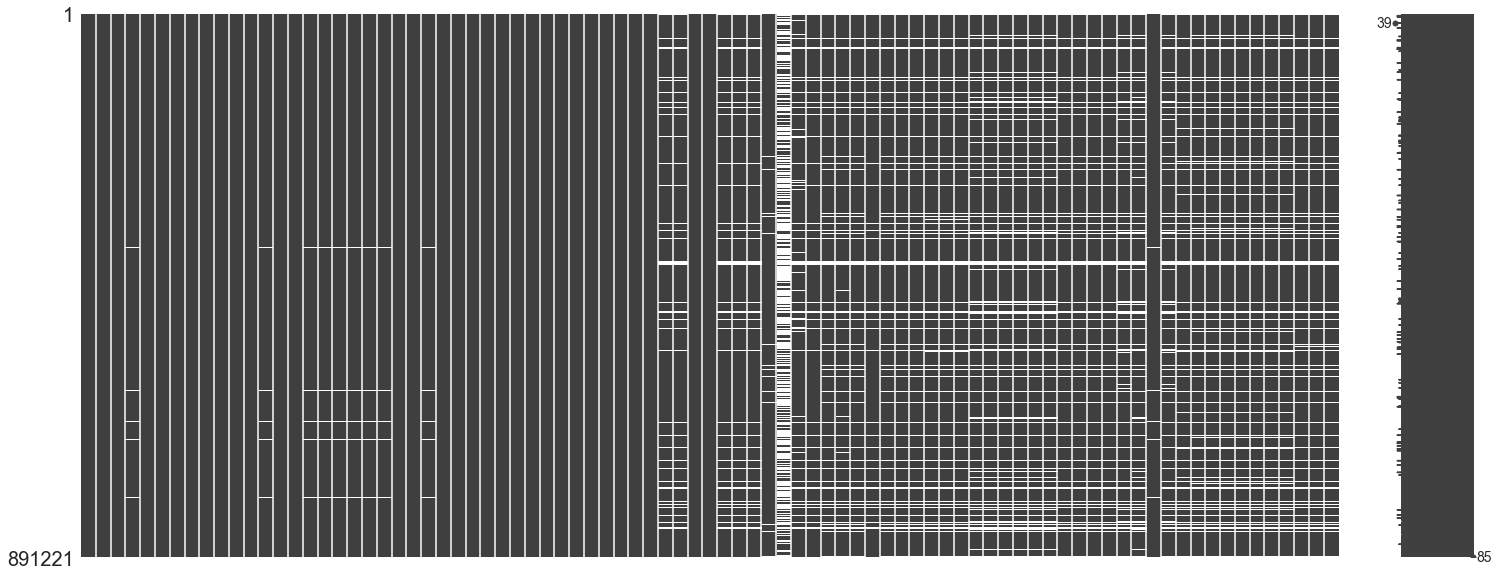

In [8]:
missingno.matrix(df)

Preliminary glance shows that there are certain columns with quite a number of missing data especially in the columns on the right side of the dataframe. But this is **not a true picture of the "missingness"** as missing values were also coded in ways other than the standard null values (NaN).

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [10]:
#Take a look at the datatype of an entry in the missing or unknown column
feat_info['missing_or_unknown'][0]

'[-1,0]'

In [11]:
#Take a look at the datatype of an entry in the missing or unknown column
feat_info['missing_or_unknown'][58]

'[XX]'

Missing values in the features summary are stored strings of list. 
We will use a function to first convert the strings of list to lists of string elements, and for each string element in a list, recast it as as integer if possible else keep as as string.

#### Standardise missing values to NaN

In [12]:
def string_to_list(x):
    '''
    Converts a string to list. 
    For each element of the list, it will try to turn it into an integer 
    Else it will be kept as a string datatype.
    '''
    mylist=[]    

    for i in x[1:-1].split(','):
        try: 
            mylist.append(int(i))
        except:
            mylist.append(i)
    return mylist

In [13]:
# Apply string_to_list function to the missing_or_unknown column
feat_info['NA_codes'] = feat_info['missing_or_unknown'].apply(string_to_list)

In [14]:
# Print features summary dataframe
feat_info

,attribute,information_level,type,missing_or_unknown,NA_codes
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [15]:
# Check that a couple of NA_codes entries to ensure they are encoded as lists of elements with string or integer type
feat_info['NA_codes'][58]

['XX']

In [16]:
feat_info['NA_codes'][0]

[-1, 0]

In [17]:
# Extract 'NA codes' column as a Pandas series
feat_info2 = feat_info.set_index('attribute')['NA_codes']

In [18]:
# Replace missing codes in dataset with NaN to standardize missing values coding
for c in df.columns:
    df[c] = df[c].mask(df[c].isin(feat_info2[c]))

In [19]:
df.isnull().sum().sort_values(ascending=False)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
CAMEO_DEU_2015            99352
CAMEO_DE

In [20]:
df.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,4,NaN,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,1,1996.0,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,NaN,2.0,5,NaN,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,1,1979.0,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,NaN,1.0,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,NaN,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,6,1957.0,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,NaN,1.0,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,5,1963.0,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,NaN,2.0,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,NaN,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,2,1943.0,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,NaN,2.0,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,4,NaN,12.0,0,2.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,10.0,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1.0,0.0,NaN,1.0,4,NaN,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,5,1964.0,9.0,0,1.0,5.0,2.0,1.0,1.0,1.0,1.0,1.0,8.0,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0.0,0.0,NaN,1.0,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,NaN,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,6,1974.0,3.0,1,3.0,10.0,3.0,1.0,1.0,10.0,5.0,1.0,11.0,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3.0,0.0,NaN,2.0,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,1,1975.0,12.0,1,2.0,4.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3.0,0.0,NaN,2.0,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,NaN,2.0,6.

In [21]:
# Check a few columns to see if the original missing codes has disappeared. 
df['ALTER_HH'].value_counts()

18.0    60852
17.0    55665
19.0    52890
15.0    51867
16.0    51857
14.0    44275
21.0    41610
20.0    40671
13.0    37612
12.0    34923
10.0    30419
11.0    27924
9.0     22817
8.0     13463
7.0      8419
6.0      3809
5.0      1030
4.0       603
3.0       200
2.0        47
1.0         1
Name: ALTER_HH, dtype: int64

In [22]:
df['CAMEO_INTL_2015'].value_counts()

51    133694
41     92336
24     91158
14     62884
43     56672
54     45391
25     39628
22     33155
23     26750
13     26336
45     26132
55     23955
52     20542
31     19024
34     18524
15     16974
44     14820
12     13249
35     10356
32     10354
33      9935
Name: CAMEO_INTL_2015, dtype: int64

In [23]:
# Extent of missing values NaN after missing codes standardised
print(f"Total number of missing values all recoded to NaN: {df.isnull().sum().sum():,}")
print(f"Percentage of missing values all recoded NaN: {df.isnull().sum().sum()/(df.shape[0]*df.shape[1]):.2%}")

Total number of missing values all recoded to NaN: 8,373,929
Percentage of missing values all recoded NaN: 11.05%


As expected, the % of missing values after standardising to NaN is higher.

#### Step 1.1.2: Assess Missing Data in Each Column after standardising missing values to NaN

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. 

While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [24]:
# Count of missing data in each column
missing_count = df.isnull().sum()

print(f"There are {sum(missing_count >0)} columns with missing data.")
print(f"There are {sum(missing_count == 0)} columns with COMPLETELY NO missing data.")

There are 61 columns with missing data.
There are 24 columns with COMPLETELY NO missing data.


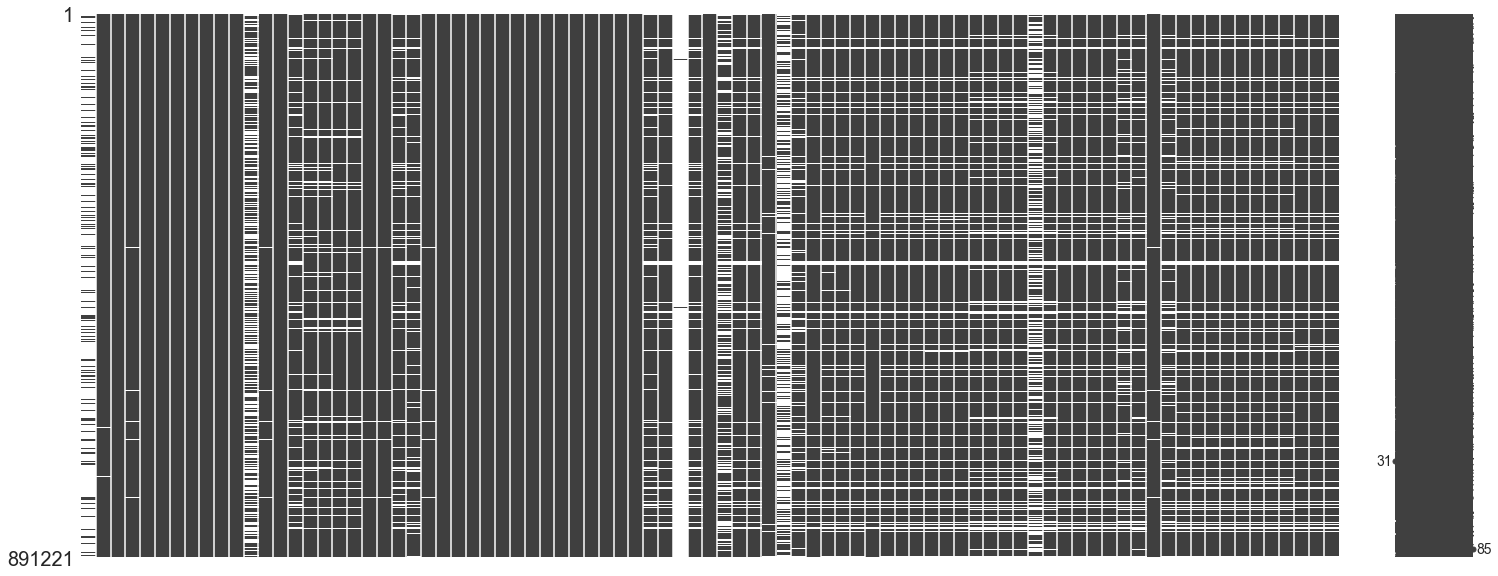

In [25]:
# Visualize patterns in the amount of missing data in each column.
missingno.matrix(df)

By visual inspection, we can discern two patterns of missingness column-wise and row-wise
 1. About 5-6 columns have a large number of missing data. 
 3. There are quite a number of records (rows) with sparse data in the right half of the dataframe

Text(0.5, 1.0, 'Distribution of columnwise missing values')

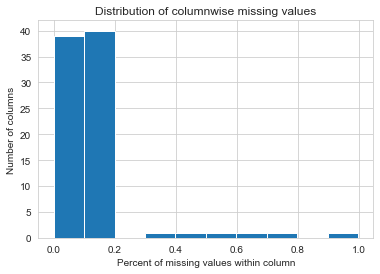

In [26]:
# Percentage of columnwise missing values
missing_count_pc = missing_count/len(df)

# Plot Histogram of ccolumnwise missing values
plt.hist(missing_count_pc)
plt.xlabel("Percent of missing values within column")
plt.ylabel("Number of columns")
plt.title("Distribution of columnwise missing values")

From the plot, there are 6 columns with approximately 30% or more missing data. The rest have less than 20% missing data.

In [27]:
# Proportion of missing values sorted in descending order
df.isnull().sum().sort_values(ascending=False)/len(df)

TITEL_KZ                 0.997576
AGER_TYP                 0.769554
KK_KUNDENTYP             0.655967
KBA05_BAUMAX             0.534687
GEBURTSJAHR              0.440203
ALTER_HH                 0.348137
REGIOTYP                 0.177357
KKK                      0.177357
W_KEIT_KIND_HH           0.166051
KBA05_ANTG4              0.149597
KBA05_GBZ                0.149597
MOBI_REGIO               0.149597
KBA05_ANTG1              0.149597
KBA05_ANTG2              0.149597
KBA05_ANTG3              0.149597
PLZ8_GBZ                 0.130736
PLZ8_HHZ                 0.130736
PLZ8_BAUMAX              0.130736
PLZ8_ANTG4               0.130736
PLZ8_ANTG1               0.130736
PLZ8_ANTG3               0.130736
PLZ8_ANTG2               0.130736
SHOPPER_TYP              0.124768
VERS_TYP                 0.124768
HEALTH_TYP               0.124768
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
KBA13_ANZAHL_PKW         0.118714
ANZ_HAUSHALTE_AKTIV      0.111769
CAMEO_INTL_201

In [28]:
# Proportion of missing values sorted in descending order
df.isnull().sum().sort_values(ascending=False).head(10)

TITEL_KZ          889061
AGER_TYP          685843
KK_KUNDENTYP      584612
KBA05_BAUMAX      476524
GEBURTSJAHR       392318
ALTER_HH          310267
REGIOTYP          158064
KKK               158064
W_KEIT_KIND_HH    147988
KBA05_ANTG4       133324
dtype: int64

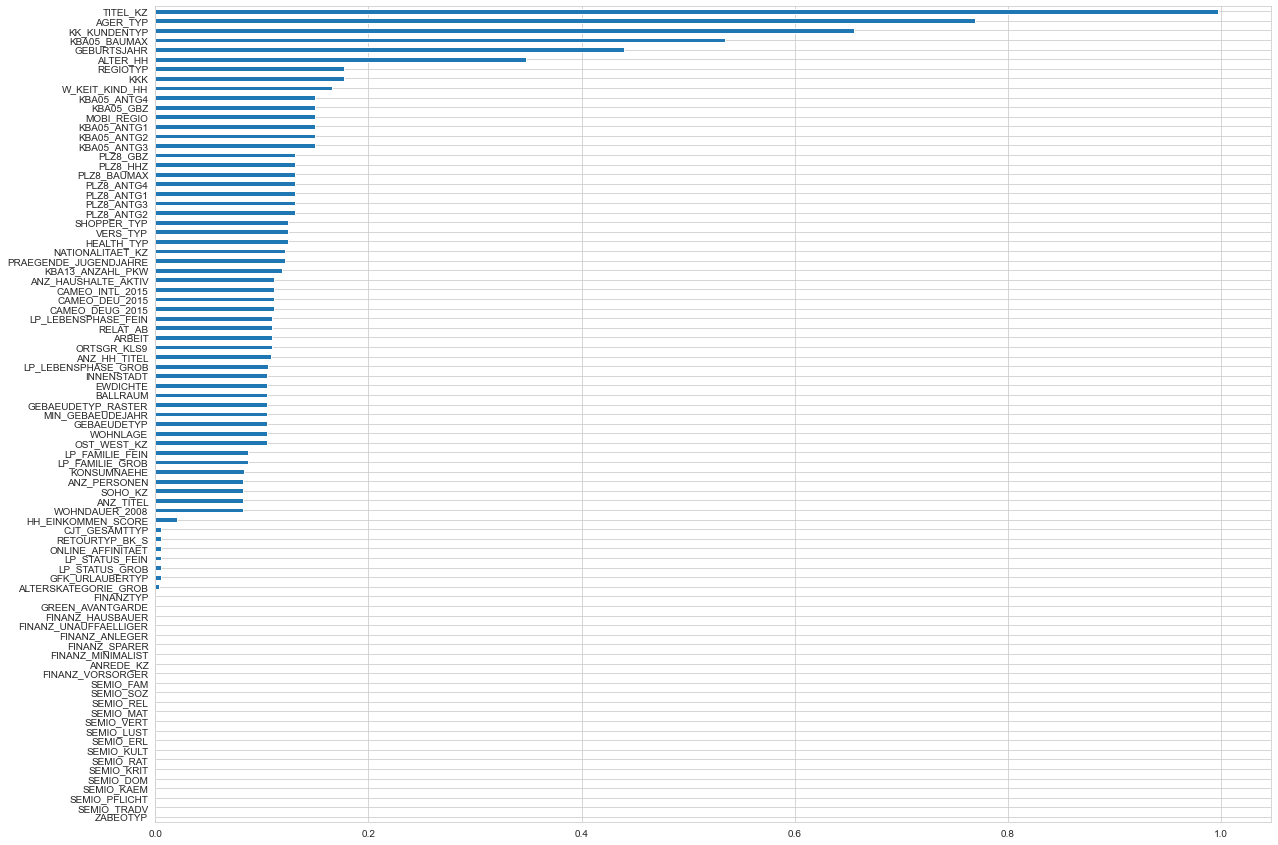

In [29]:
#  Use barplot to view each column names and their "missingness"
fig, ax = plt.subplots(figsize=(20, 15))

missing_count_pc.sort_values(ascending=True).plot.barh()

In [30]:
# Drop the six columns with >30% missing data

cols_to_drop = ['AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_HH']  
df.drop(columns= cols_to_drop, inplace = True)


In [31]:
#Check dataframe, 85-6 -->79 columns remaining
print(df.shape)

(891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

*(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)*

Initial evaluation of the raw data showed that the missingness was about 6.46%.  

However, as indicated in the features summary table, the data's missing values have also been coded in ways other than NaN. 

Therefore before we could evaluate the missingness in the data, we have to standardise all the missing codes to NaN. The % of missing data increased to 11.05%.

Next, we assessed the amount of missing data in each column. Six columns showed >30% missing data and will be dropped in subsequent analysis:
- 'AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_HH'  

Visualization of the missingness by way of the missingno matrix plot also helps us to appreciate the extent of row-wise missingness in the dataset. Interestingly, most of the rows with missing data affect the columns on the right side of the dataframe. We will deal with the row-wise missingness next.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

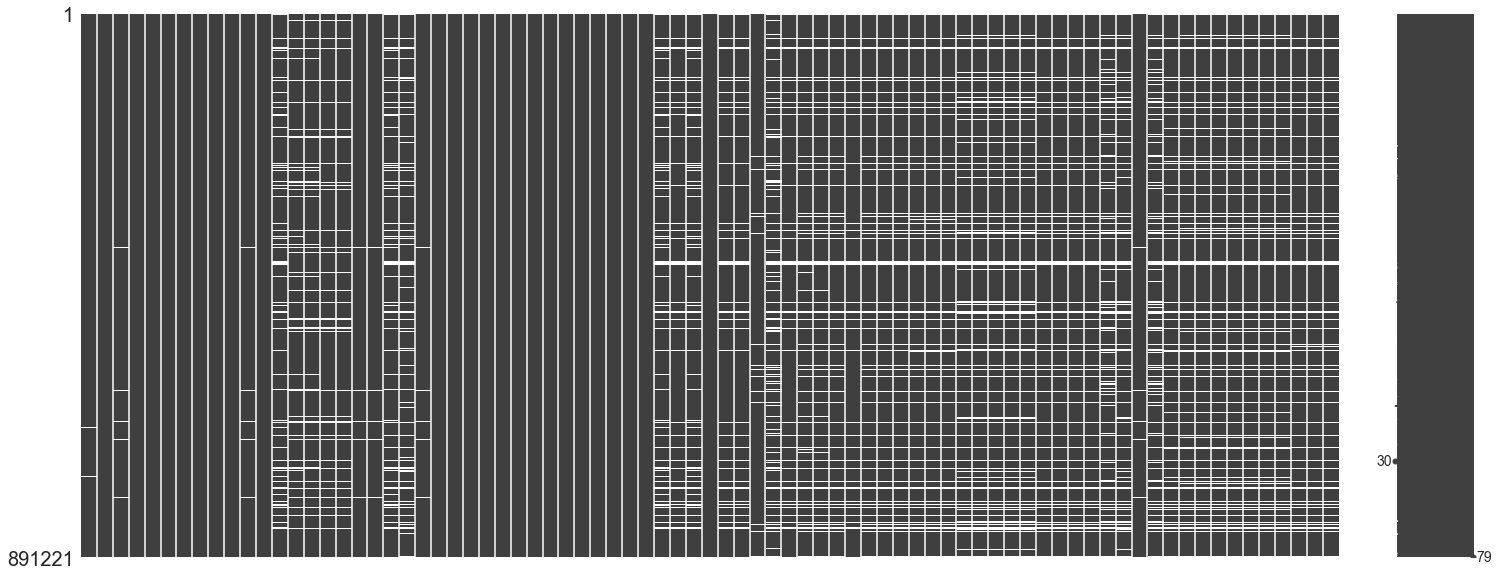

In [32]:
# How much data is missing in each row of the dataset?
missingno.matrix(df)

In [33]:
# How many rows/records have missing entries? 
missing_count_by_row = df.isnull().sum(axis =1)

print(f"Percent of rows with missing data {sum(missing_count_by_row.sort_values()>0)/len(df):.2%}")

Percent of rows with missing data 30.07%


In [34]:
# Glue row count of missing nan as a new column to dataframe
df['count_na'] = missing_count_by_row 

Text(0.5, 0, '# of missing values')

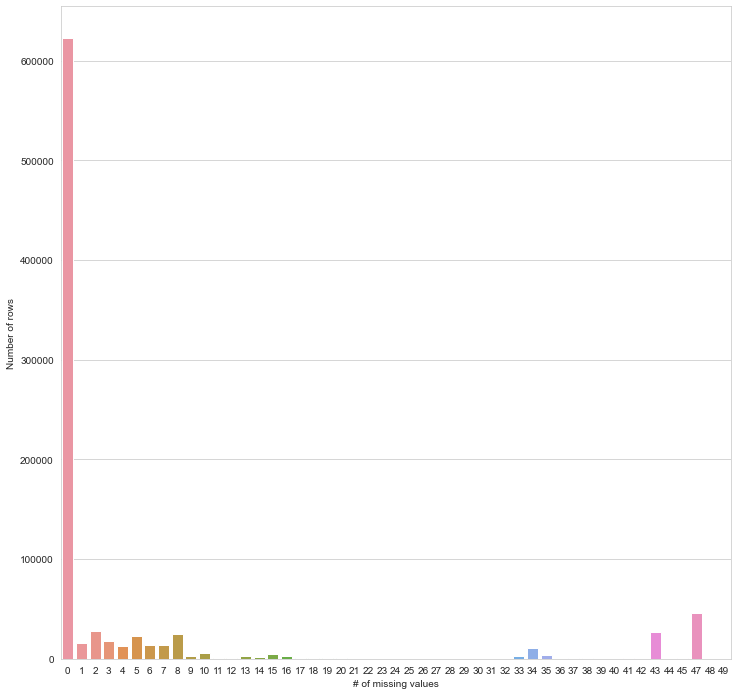

In [35]:
#Plot countplot
plt.figure(figsize=(12,12))
sns.countplot(x = 'count_na', data = df)
plt.ylabel("Number of rows")
plt.xlabel("# of missing values")

In [36]:
df['count_na'].value_counts().sort_index(ascending=False)

49         2
48         1
47     45578
45       494
44       155
43     27369
42        21
41       356
40       137
39        77
38       421
37       538
36        84
35      3911
34     10816
33      2985
32       206
31         3
30         6
29        12
28         5
27        24
26        59
25        55
24        69
23       132
22       129
21       150
20       349
19      1180
18       428
17       677
16      2505
15      4743
14      2243
13      3255
12       766
11      1127
10      5410
9       3042
8      24592
7      13714
6      13771
5      22515
4      12607
3      17629
2      27926
1      15738
0     623209
Name: count_na, dtype: int64

The histogram confirms that there are two subsets of data: rows with ~ <30 missing values, and rows with ~>=30 missing values. This is consistent with our earlier missingness matrix visualization where we saw there are rows with quite a number of sparse data.  

Thus we will divide the data into TWO subsets using 30 as a cutoff.

In [37]:
# Divide the data into TWO SUBSETS based on the row-wise missing counts with 30 as cutoff.
# Also slice out the count_na column appended earlier
df_30 = df[df['count_na']<30].iloc[:, :-1]
df_30plus =df[df['count_na']>=30].iloc[:, :-1]
print("Shape of subset with < 30 missing values in row", df_30.shape)
print("Shape of subset with >= 30 missing values in row", df_30plus.shape)
print("Proportion of rows retained in df_30: ", df_30.shape[0]/df.shape[0])

Shape of subset with < 30 missing values in row (798061, 79)
Shape of subset with >= 30 missing values in row (93160, 79)
Proportion of rows retained in df_30:  0.895469249490306


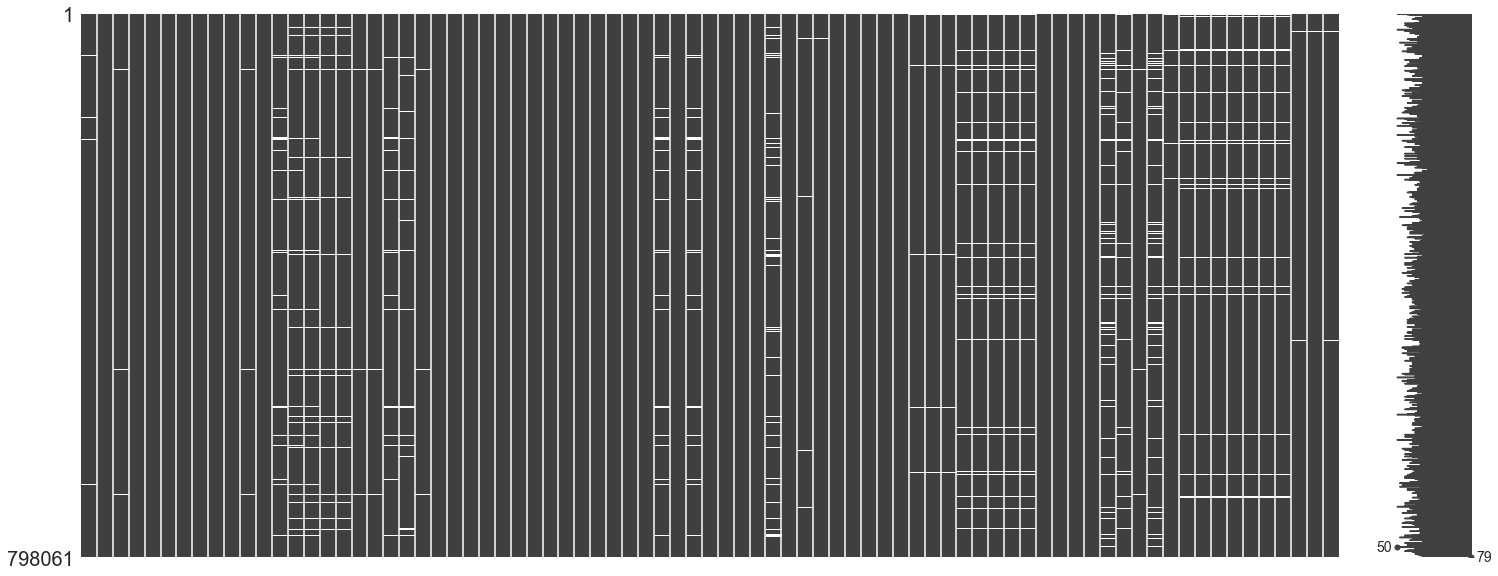

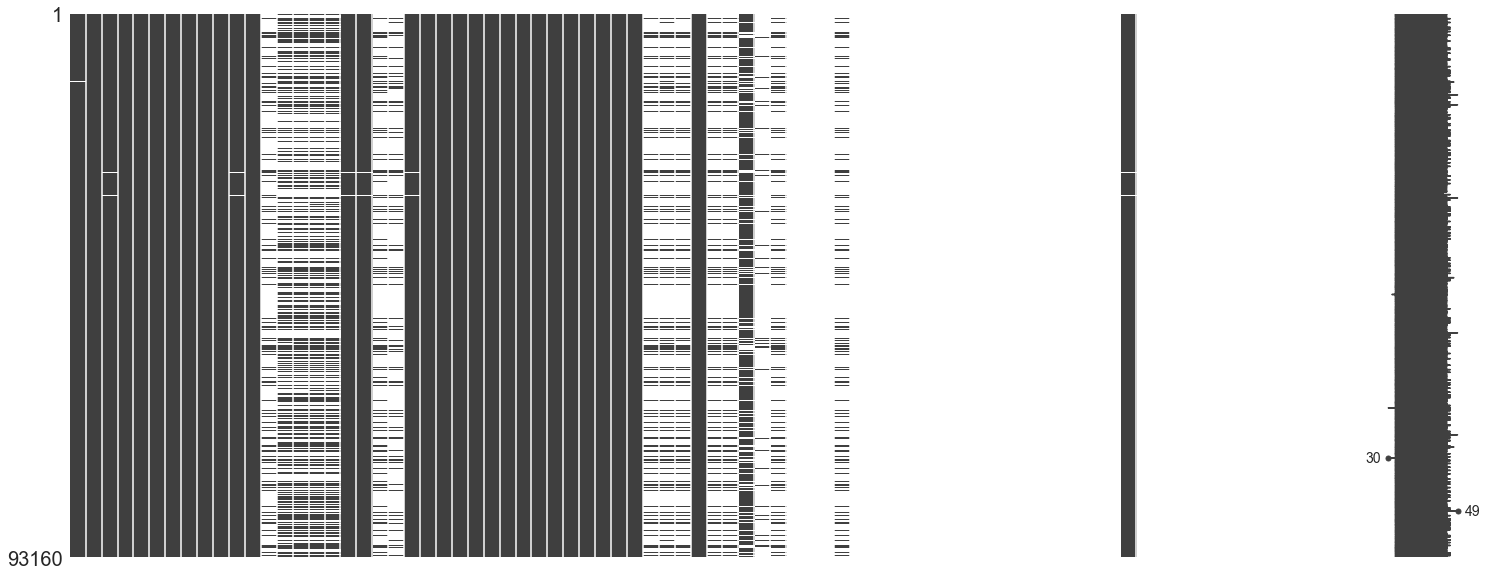

In [38]:
# Visualizing the missingness in the dataframes
missingno.matrix(df_30)
missingno.matrix(df_30plus)

The missingness matrix highlights the dramatic contrast between the two subsets. The smaller subset has more than half of the columns with complete or mostly missing data, especially on the right side of the dataframe. 

In [39]:
#Missing values in each column of df_30 subset
df_30_missing_count =pd.Series(df_30.isnull().sum(), name='df_30_missing_count')

#Missing values in each column of df_30 plus subset
df_30plus_missing_count =pd.Series(df_30plus.isnull().sum(), name='df_30plus_missing_count')

missing_count_subsets = pd.concat([df_30_missing_count , df_30plus_missing_count], axis=1)
missing_count_subsets

,df_30_missing_count,df_30plus_missing_count
ALTERSKATEGORIE_GROB,2803,78
ANREDE_KZ,0,0
CJT_GESAMTTYP,4745,109
FINANZ_MINIMALIST,0,0
FINANZ_SPARER,0,0
FINANZ_VORSORGER,0,0
FINANZ_ANLEGER,0,0
FINANZ_UNAUFFAELLIGER,0,0
FINANZ_HAUSBAUER,0,0
FINANZTYP,0,0


24 columns have no missing data in both subsets.

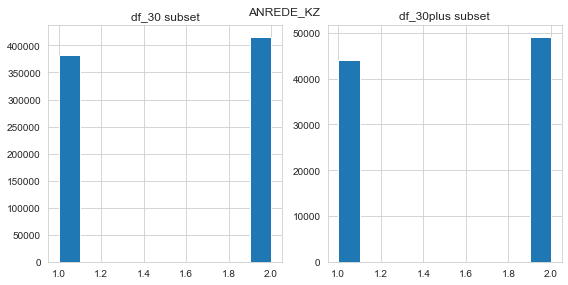

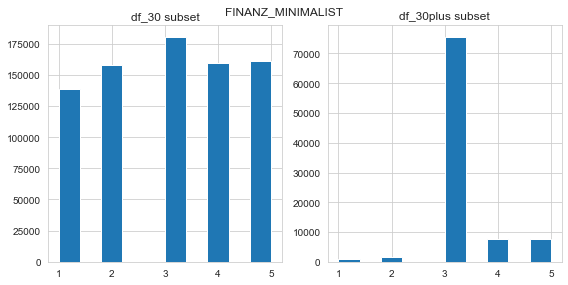

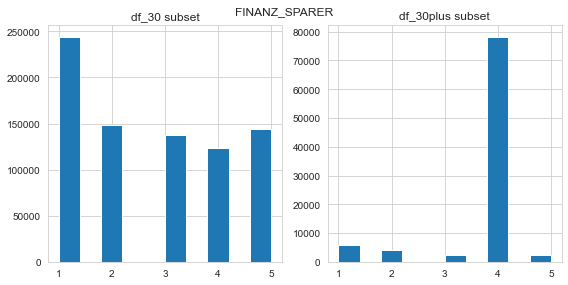

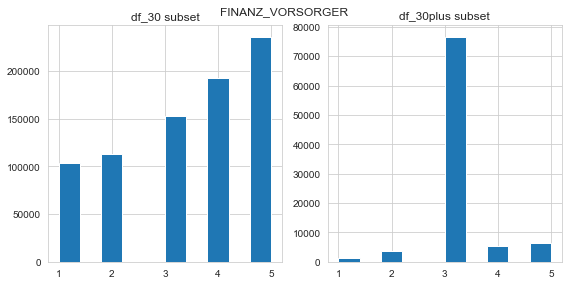

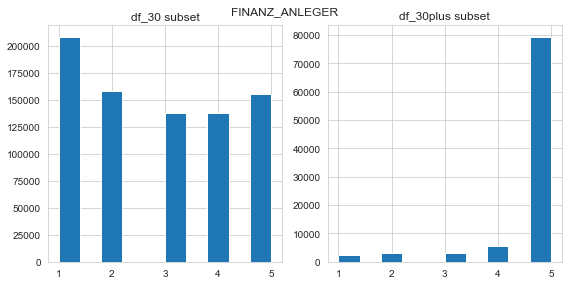

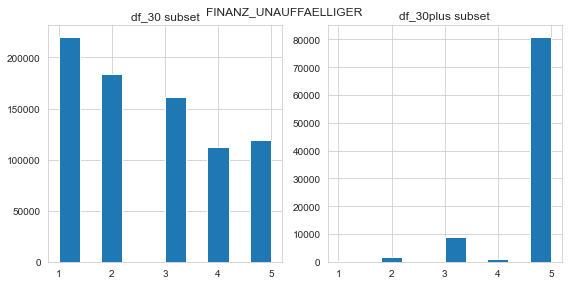

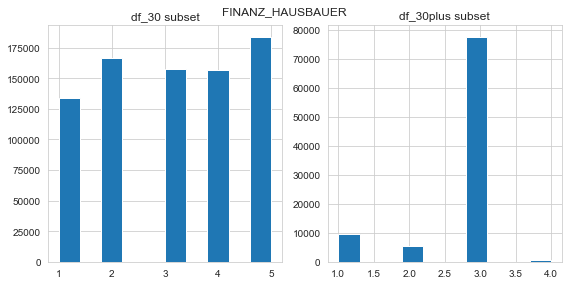

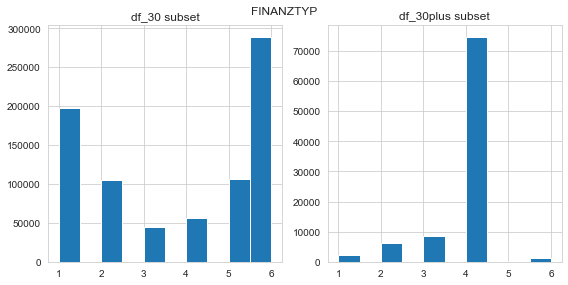

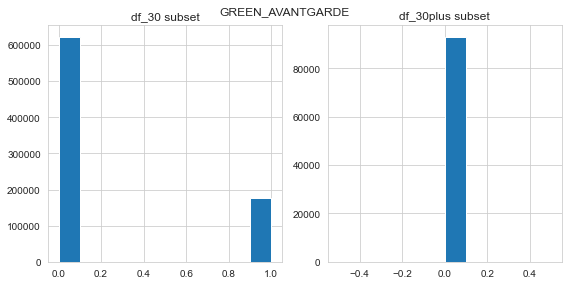

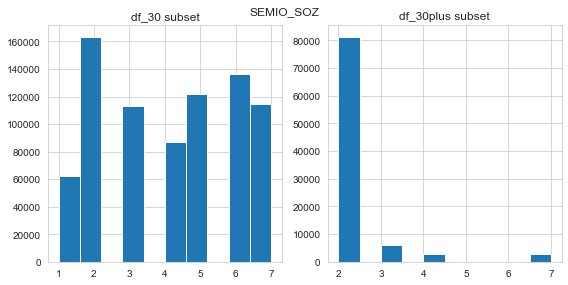

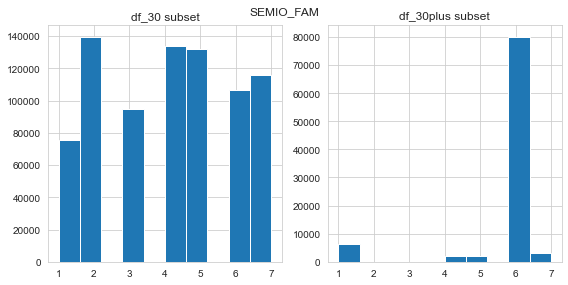

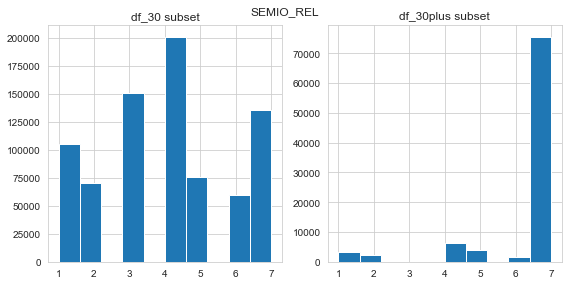

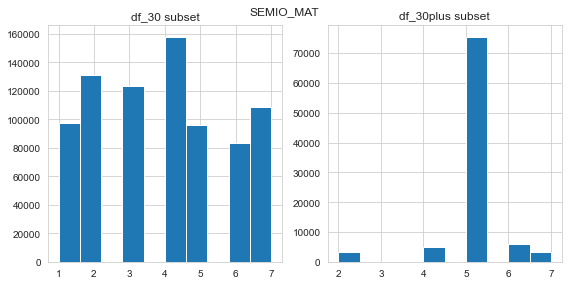

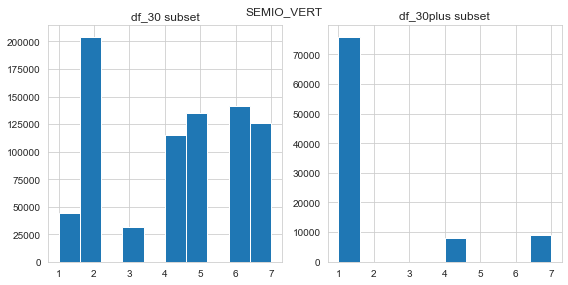

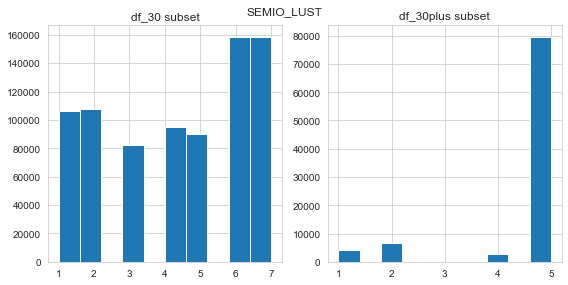

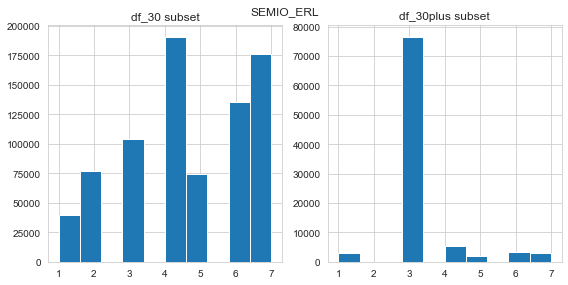

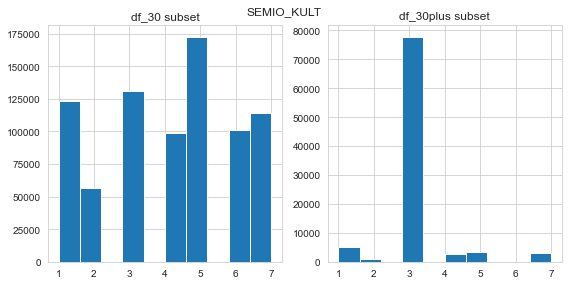

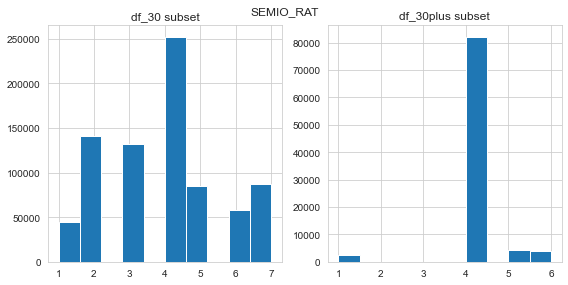

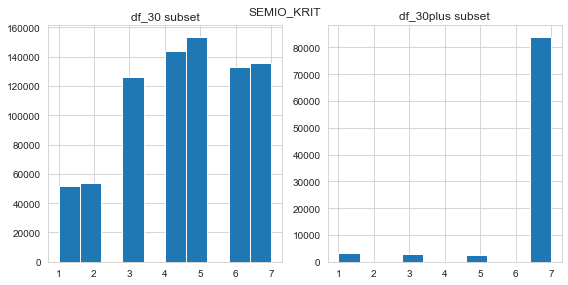

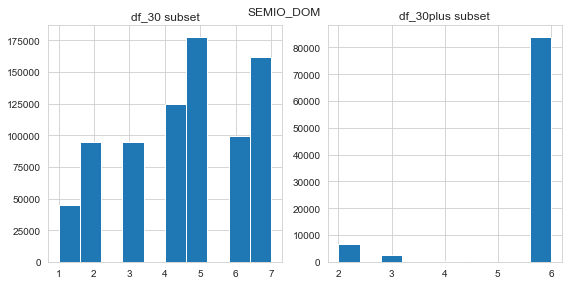

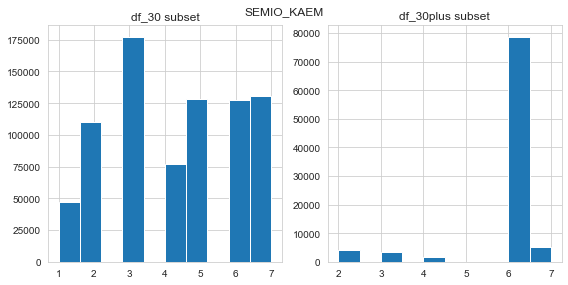

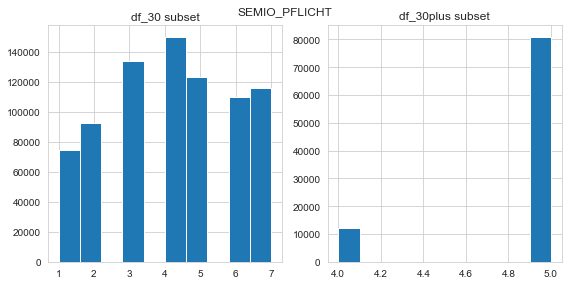

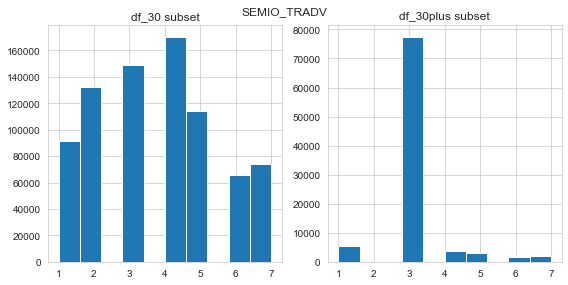

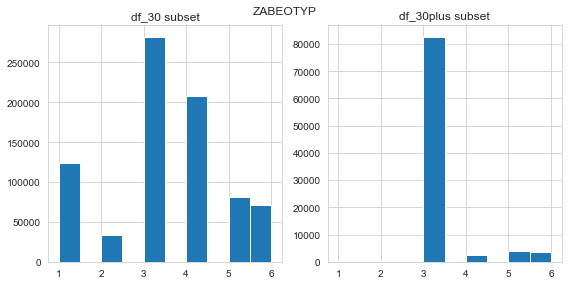

In [40]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# List of column names where both subsets have COMPLETE data. 24 of them
col_names = ['ANREDE_KZ', 'FINANZ_MINIMALIST','FINANZ_SPARER','FINANZ_VORSORGER','FINANZ_ANLEGER',
'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'FINANZTYP', 'GREEN_AVANTGARDE',
'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
'SEMIO_TRADV', 'ZABEOTYP']

# Plot the histograms of the 2 subsets side by side.
# Note: Need to fill the NaN with 0 in the dataframes, to display plots. Else error in plot
for i in range(len(col_names)):
    fig, (ax1, ax2) = plt.subplots(figsize=(8,4), ncols=2)
    ax1.hist(df_30[col_names[i]].fillna(0))   
    ax1.set_title('df_30 subset')
    ax2.hist(df_30plus[col_names[i]].fillna(0)) 
    ax2.set_title('df_30plus subset')
    plt.tight_layout()
    plt.suptitle(col_names[i])
    plt.show()

Observation:

The distributions of each variable with complete data are generally quite different between the two subsets, confirming that the two subsets are quite different and should be segregated in subsequent analysis. For example, we try to impute the missing values with the original dataset without subsettting, the imputation of missing values would be highly inaccurate.


#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Based on the row-wise missingness visualization and histogram, we subsetted the data into two on the number of missing data across row (count_na by row, <30 and >=30). 

After subsetting the data, we examined the distributions of several variables and found them to be quite different. The smaller subset has a lot of columns pertaining to features on the right side of the dataframe with completely missing data across the entire columns. These observations suggest that the missing data may not be occurring at random. 

Possible reasons for the high dropout, e.g. 
- the data were collected at different time points 
- changes in the data collection instrument (attributes were purposefully omitted, for example)
- error when data were combined  from different sources
- Incomplete data entry 

Instead of speculating, it would be wise to check with the custodian of the data for further advice in real life if we nmade such observations when processing the data.

Subsequent our analysis will focus on df_30 subset, which retains about 90% of rows in original dataset

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.



In the first two parts of this sub-step, you will perform **an investigation of the categorical and mixed-type features** and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [41]:
feat_info

,attribute,information_level,type,missing_or_unknown,NA_codes
0,AGER_TYP,person,categorical,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]


In [42]:
# In the initial missing count by column analysis, we removed three columns from the azdias dataset
# We will also drop the 3 features from the features summary table

cols_to_drop = ['AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_HH']  

# Update our feat_info info table
feat_info_79= feat_info.mask(feat_info['attribute'].isin(cols_to_drop)).dropna()
feat_info_79

,attribute,information_level,type,missing_or_unknown,NA_codes
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]
10,FINANZTYP,person,categorical,[-1],[-1]


In [43]:
# How many features are there of each data type?
feat_info_79['type'].value_counts()

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

According to the features summary, there are 18 columns and 6 columns with categorical and mixed datatypes respectively.

In [44]:
#List of categorical attributes
categorical = list(feat_info_79[feat_info_79['type']=='categorical']['attribute'])

#List of categorical attributes
mixed = list(feat_info_79[feat_info_79['type']=='mixed']['attribute'])

print("List of categorical attributes: ", categorical)
print("List of mixed attributes:", mixed)

List of categorical attributes:  ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
List of mixed attributes: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', 'PLZ8_BAUMAX']


In [45]:
mixed

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [46]:
# Subsetting of dataframe with categorical
df_30_cat =df_30[categorical]

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

### Assess categorical variables: which are binary, which are multi-level, and which one needs to be re-encoded?


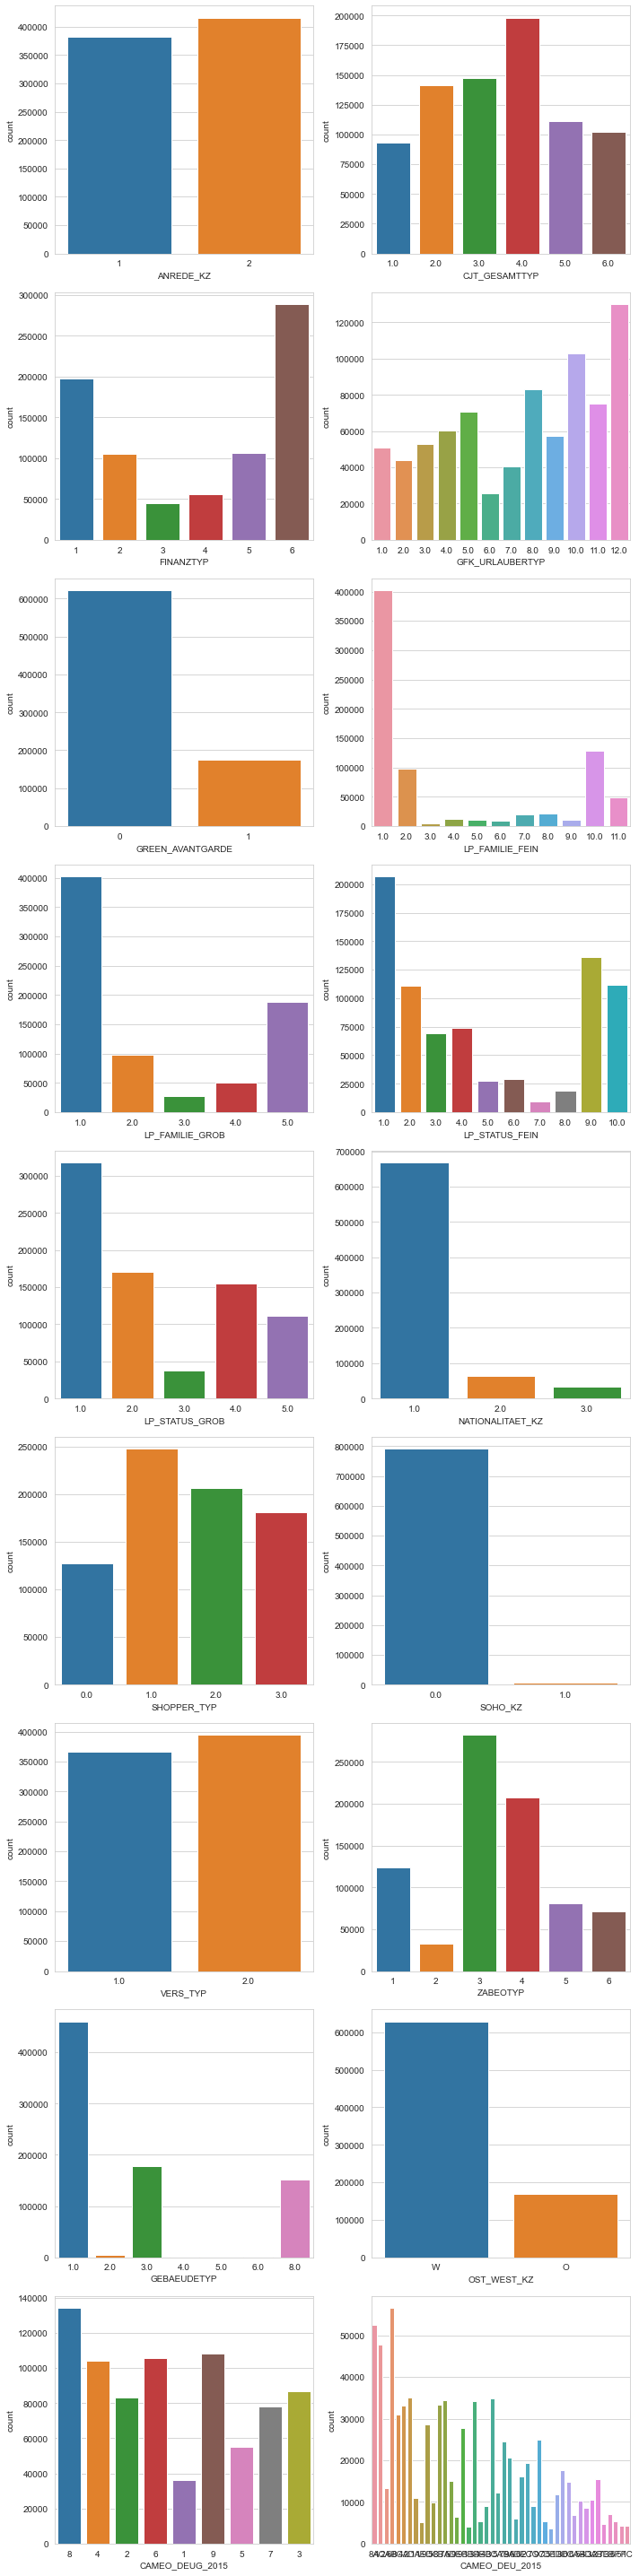

In [47]:
# Using a loop to create multiple countplots of the categorical variables
fig, axes = plt.subplots(9,2, figsize=(10,40))

# Subplot is in 2D numpy array, so need to flatten it before ploting
axes = axes.flatten()

for i in range(18):
    sns.countplot(data=df_30_cat, x = df_30_cat.iloc[:, i], ax=axes[i])  
plt.tight_layout()
plt.show()

From the countplots of the categorical columns, we make two observations
- CAMEO_DEU_2015 have many categories in non-numerical codes
- GEBAEDETYP seems to have very low counts for some categories. 

In [48]:
# Check how many value_labels are there in CAMEO_DEU_2015
len(df_30_cat['CAMEO_DEU_2015'].value_counts())

44

In [49]:
df_30['GEBAEUDETYP'].value_counts()

1.0    460460
3.0    178666
8.0    152474
2.0      4932
4.0       900
6.0       628
5.0         1
Name: GEBAEUDETYP, dtype: int64

Column ['GEBAEUDETYP'] column has a label 5.0 that only appears once. This could be a data entry error or spurious response so let's change it to NaN.

In [50]:
# Replace the singleton with NaN
df_30['GEBAEUDETYP'].replace(5.0, np.nan, inplace = True)

In [51]:
# Check that we have gotten rid of the singleton
df_30['GEBAEUDETYP'].value_counts()

1.0    460460
3.0    178666
8.0    152474
2.0      4932
4.0       900
6.0       628
Name: GEBAEUDETYP, dtype: int64

In [52]:
# Count of the value labels for categorical attributes
for i in range(18):
    k,v = df_30_cat.columns[i],  len(df_30_cat.iloc[:, i].value_counts().index)
    print(k,":", v)

ANREDE_KZ : 2
CJT_GESAMTTYP : 6
FINANZTYP : 6
GFK_URLAUBERTYP : 12
GREEN_AVANTGARDE : 2
LP_FAMILIE_FEIN : 11
LP_FAMILIE_GROB : 5
LP_STATUS_FEIN : 10
LP_STATUS_GROB : 5
NATIONALITAET_KZ : 3
SHOPPER_TYP : 4
SOHO_KZ : 2
VERS_TYP : 2
ZABEOTYP : 6
GEBAEUDETYP : 7
OST_WEST_KZ : 2
CAMEO_DEUG_2015 : 9
CAMEO_DEU_2015 : 44


BInary categoricals : ['ANREDE_KZ', 'GREEN_AVANTGARDE','SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

Multi-label categoricals (between 3 to 12 labels):
CJT_GESAMTTYP,FINANZTYP,GFK_URLAUBERTYP,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,
LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,SHOPPER_TYP,,ZABEOTYP,
GEBAEUDETYP,CAMEO_DEUG_2015

Categoricals with non-numerical labels:
- CAMEO_DEU_2015  (44 categoricals) --->many categories, drop this column from dataset; also the info appears to be duplicated in CAMEO_INTL_2015
- OST_WEST_KZ (binary) --->Recode to numerical

In [53]:
# Recode OST_WEST_KZ to numerical in df_30 subset
df_30['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)
df_30['OST_WEST_KZ'].value_counts()

0    629520
1    168541
Name: OST_WEST_KZ, dtype: int64

In [54]:
list(df_30.columns)

['ALTERSKATEGORIE_GROB',
 'ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'HEALTH_TYP',
 'LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'PRAEGENDE_JUGENDJAHRE',
 'RETOURTYP_BK_S',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'HH_EINKOMMEN_SCORE',
 'W_KEIT_KIND_HH',
 'WOHNDAUER_2008',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'GEBAEUDETYP',
 'KONSUMNAEHE',
 'MIN_GEBAEUDEJAHR',
 'OST_WEST_KZ',
 'WOHNLAGE',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CAMEO_INTL_2015',
 'KBA05_ANTG1',
 'K

In [55]:
# Drop 'CAMEO_DEU_2015' from further analysis
df_30.drop(columns=['CAMEO_DEU_2015'], inplace=True)

# Confirm colums have been dropped. Since 6 were dropped earlier, we should have 85-6-1 =78 columns left
df_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,0,4.0,8,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,0,2.0,4,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,0,7.0,2,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,0,3.0,6,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,0,7.0,8,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0


In [56]:
df_30.shape

(798061, 78)

Text(0.5, 1.0, 'Row-wise missing count')

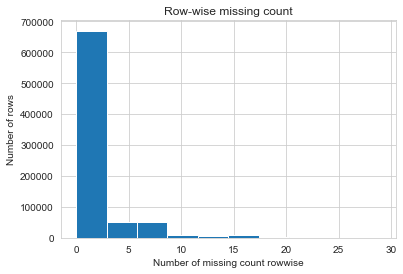

In [57]:
#Plot of columns with their row-wise missing count
df_30.isnull().sum(axis=1).sort_values(ascending=False).hist()
plt.ylabel("Number of rows")
plt.xlabel("Number of missing count rowwise")
plt.title("Row-wise missing count")

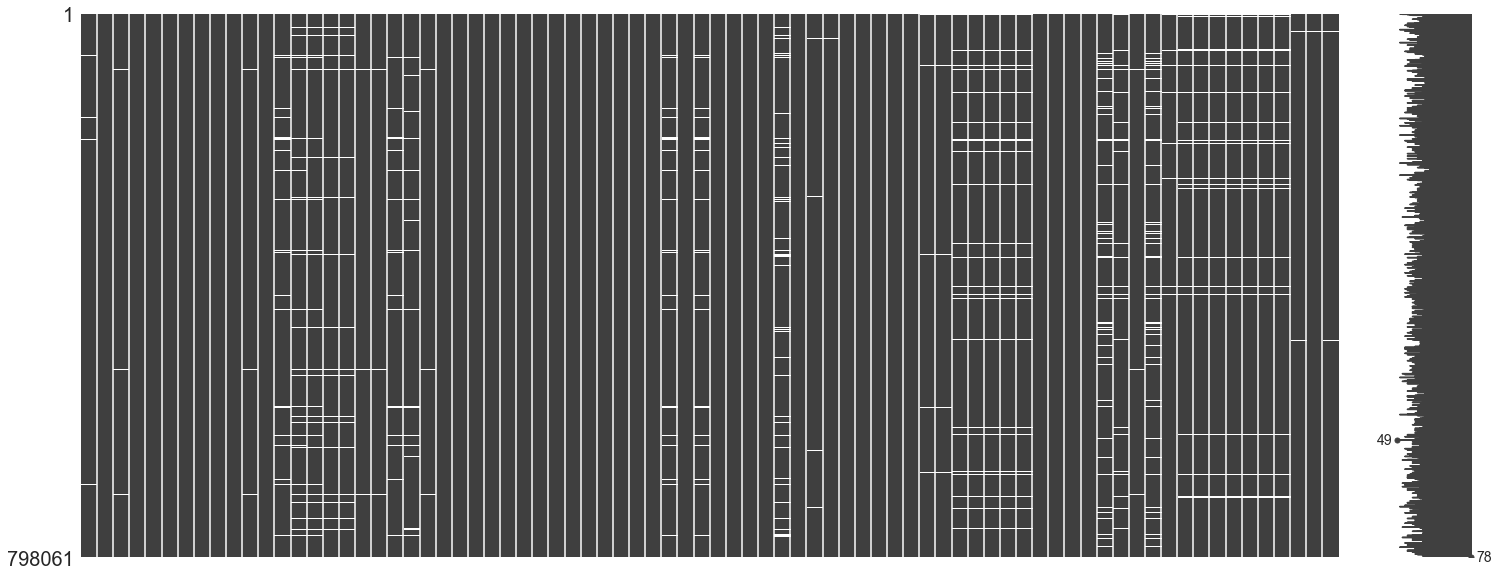

In [58]:
#Visualize dataframe
missingno.matrix(df_30)

At this stage of the data wrangling, the small amount of missing data in the small subset looks acceptable.

#### Notes on processing done thus far:

- Standardise missing values to NaN -->11.05% of missing values
- Drop 6 columns with excessive missing data
- Divide dataset into two, based on missingness in rows. Retain df_30 for analysis, which is about 90% of original dataset
- Getting to know our categorical data: Drop 1 multi-label column (1 with 44 non-numerical labels) ,and recode a binary column into numerical code. 

At this stage of the data wrangling, the small amount of missing data in the small subset looks acceptable and we will proceed with using this subset

#### Dummies coding on multi-label categoricals

In [59]:
# Use Pandas dummies encoding on the multi-label categoricals
# Note: we can't use ONe-Label Encoder as we would have to get rid of NaN values first

multi_label_cat = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_FAMILIE_GROB', 
                   'LP_STATUS_FEIN',
                   'LP_STATUS_GROB',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP', 
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015']

df_30 =pd.get_dummies(df_30, columns=multi_label_cat)

In [60]:
#Print first 5 rows to check encoding
df_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,...,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,0,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,...,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,0,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,...,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,0,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,0,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,...,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,0,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,...,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


#### Discussion 1.2.1: Re-Encode Categorical Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

##### Categorical Features Processing

Two Categorical columns have non-numerical labels
- CAMEO_DEU_2015 (44 categoricals) --->Drop this column from dataset
- OST_WEST_KZ (binary) --->Recode to numerical

Another observation
- GEBAEUDETYP'== 5.0 only has one count. This is likely to be a spurious entry and we re-coded this to NaN instead. (As we shall see later, the customer dataset does not have this label, and if we were to retain it in the general dataset, we would run into problems when we fit the sklearn models to the customer dataset because of the mismatch in number of columns in the two datasets).

Lastly all, mutilabel categoricals converted to dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.



### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [61]:
df_30['PRAEGENDE_JUGENDJAHRE'].value_counts(dropna=False).sort_index()

1.0      20678
2.0       7479
3.0      53845
4.0      20451
5.0      84691
6.0      25652
7.0       4010
8.0     141630
9.0      33570
10.0     85808
11.0     35752
12.0     24446
13.0      5764
14.0    182983
15.0     42547
NaN      28755
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [62]:
# Remap PRAEGENDE_JUGENDJAHRE into new "generation" column
# 1, 2 -->0 (40s)
# 3, 4 -->1 (50s)
# 5 to 7 -->2 (60s)
# 8 to 9 -->3 (70s)
#10 to 13-->4 (80s)
#14-15 -->5 (90s)

df_30['generation'] = df_30['PRAEGENDE_JUGENDJAHRE'].map({1:0, 2:0,
                                                          3:1, 4:1,
                                                          5:2, 6:2, 7:2,
                                                          8:3, 9:3,
                                                          10:4, 11:4, 12:4, 13:4,
                                                          14:5, 15:5})

In [63]:
#Confirm recoding is correct
df_30['generation'].value_counts(dropna = False)

5.0    225530
3.0    175200
4.0    151770
2.0    114353
1.0     74296
NaN     28755
0.0     28157
Name: generation, dtype: int64

In [64]:
# Remap PRAEGENDE_JUGENDJAHRE into new "movement" column
# 1,3,4,8, 10,12,14 -->0 ( Mainstream)
# 2,4,6,7,11,12,13,15  -->1 (Avantgarde)

df_30['movement'] = df_30['PRAEGENDE_JUGENDJAHRE'].map({1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
                                                        2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1})

In [65]:
#Confirm recoding is correct
df_30['movement'].value_counts(dropna=False)

0.0    594081
1.0    175225
NaN     28755
Name: movement, dtype: int64

#### Investigate "CAMEO_INTL_2015" and engineer two new variables.



### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown


In [66]:
# Remap "CAMEO_INTL_2015" column into new "wealth" column
# 12 to 15 : 0 (wealthy)), 22 to 25 : 1 (Prosperous) , 31 to 35 : 2 (Comfortable) 
# 41 to 45 :3 (Less affluent), 51, 52,  55 :4 (Poor)

df_30['wealth'] = df_30['CAMEO_INTL_2015'].map({"11":0, "12":0, "13":0,"14":0, "15":0,
                                                "21":1, "22":1, "23":1,"24":1, "25":1,
                                                "31":2, "32":2, "33":2, "34":2, "35":2,
                                                "41":3, "42":3, "43":3, "44":3, "45":3,
                                                "51":4, "52":4, "53":4, "54":4, "55":4})

In [67]:
df_30['wealth'].value_counts(dropna=False).sort_index()

0.0    119442
1.0    190687
2.0     68192
3.0    189960
4.0    223582
NaN      6198
Name: wealth, dtype: int64

In [68]:
# Remap CAMEO INTL_2015 column into new "life_stage" column
# x1 : 0 - Pre-Family Couples & Singles
# x2 : 1 - Young Couples With Children
# x3 : 2 - Families With School Age Children
# x4 : 3 - Older Families & Mature Couples
# x5 : 4 - Elders In Retirement

df_30['life_stage'] = df_30['CAMEO_INTL_2015'].map({"11":0, "21":0, "31":0, "41":0, "51":0,
                                                    "12":1, "22":1, "32":1, "42":1, "52":1,
                                                    "13":2, "23":2, "33":2, "43":2, "53":2,
                                                    "14":3, "24":3, "34":3, "44":3, "54":3,
                                                    "15":4, "25":4, "35":4, "45":4, "55":4})

In [69]:
#Confirm recoding is correct
df_30['life_stage'].value_counts(dropna=False).sort_index()

0.0    245053
1.0     77299
2.0    119692
3.0    232776
4.0    117043
NaN      6198
Name: life_stage, dtype: int64

In [70]:
#Print shape of dataframe before droppping columns
df_30.shape

(798061, 153)

In [71]:
# Drop the 2 columns that were re-engineered as well the other mixed datatypes 

cols_to_drop = ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', \
                    'PRAEGENDE_JUGENDJAHRE', 'WOHNLAGE', 'CAMEO_INTL_2015', \
                     'PLZ8_BAUMAX']

df_30.drop(columns= cols_to_drop, inplace=True)      

In [72]:
df_30.shape

(798061, 147)

In [73]:
# Update features info table

cols_to_remove =  ['AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_HH',\
                       'CAMEO_DEU_2015',\
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', \
                        'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']

feat_info_72= feat_info.mask(feat_info['attribute'].isin(cols_to_remove)).dropna()
feat_info_72

,attribute,information_level,type,missing_or_unknown,NA_codes
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,person,categorical,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,person,categorical,[0],[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1],[-1]
5,FINANZ_SPARER,person,ordinal,[-1],[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1],[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1],[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1],[-1]
10,FINANZTYP,person,categorical,[-1],[-1]


In [74]:
len(feat_info_72)

72

#### Discussion 1.2.2: Engineer Mixed-Type Features

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)*

##### MIXED TYPE ENGINEERING
New columns were created from PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 by using dictionaries to remap the old to the new numerical values. After remapping, the original columns and other mixed type columns were dropped from the dataframe.

PRAEGENDE_JUGENDJAHRE into new "generation" column
- 1, 2 -->0 (40s)
- 3, 4 -->1 (50s)
- 5 to 7 -->2 (60s)
- 8 to 9 -->3 (70s)
- 10 to 13-->4 (80s)
- 14-15 -->5 (90s)

PRAEGENDE_JUGENDJAHRE into new "movement" column
- 1,3,4,8, 10,12,14 -->0 ( Mainstream)
- 2,4,6,7,11,12,13,15  -->1 (Avantgarde)

CAMEO_INTL_2015-->wealth
- 11 to 15 : 0 (wealthy)
- 21 to 25 : 1 (Prosperous)
- 31 to 35 : 2 (Comfortable) 
- 41 to 45 : 3 (Less affluent)
- 51 to 45 :4 (Poor)

CAMEO_INTL_2015--->life_stage
- x1 : 0 - Pre-Family Couples & Singles
- x2 : 1 - Young Couples With Children
- x3 : 2 - Families With School Age Children
- x4 : 3 - Older Families & Mature Couples
- x5 : 4 - Elders In Retirement

##### Updating dataframe
After re-engineering the new features, the original columns as well as the other 5 mixed type columns were dropped from the dataset. This leaves us with 79 features.



NOtes: Room for improvement---I could use if functions for the recoding and apply them to columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [75]:
df_30.shape

(798061, 147)

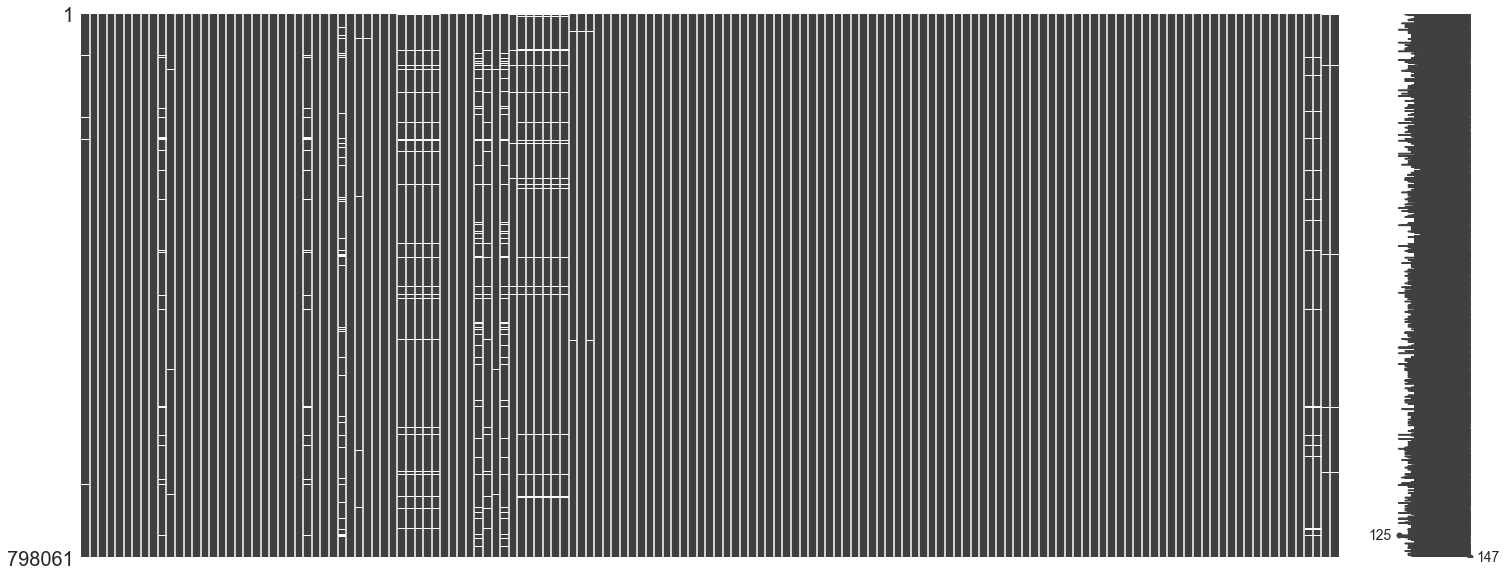

In [76]:
missingno.matrix(df_30)

Our processed dataframe looks acceptable now.

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [78]:
# Need to load in features summary and do initial processing before running this function

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    #1. Replace missing codes in dataset with NaN
    
    # Convert  "missing_or_unknown" column  from strings of list to lists of list

    for c in df.columns:
        df[c] = df[c].mask(df[c].isin(feat_info2[c]))
      
    #2. Select rows with <30 missing values
    
    missing_row_count = df.isnull().sum(axis =1)
    df['count_na'] = missing_row_count
    
    # Select rows with count_na <30 and then drop 'count_na' column
    df = df[df['count_na']<30].iloc[:, :-1]
        
    # 3. Feature engineering steps for columns
    #  Recode 'OST_WEST_KZ' to binary numerical codes 
    df['OST_WEST_KZ'].replace({'W':0, 'O':1}, inplace=True)    # Alternatively, use LabelEncoder
    
    # Dummies encoding for categorical columns
    
    multi_label_cat = ['CJT_GESAMTTYP',
                   'FINANZTYP',
                   'GFK_URLAUBERTYP',
                   'LP_FAMILIE_FEIN',
                   'LP_FAMILIE_GROB', 
                   'LP_STATUS_FEIN',
                   'LP_STATUS_GROB',
                   'NATIONALITAET_KZ',
                   'SHOPPER_TYP',
                   'ZABEOTYP', 
                   'GEBAEUDETYP',
                   'CAMEO_DEUG_2015']

    df = pd.get_dummies(df, columns=multi_label_cat)
    
    # Engineer new features ['generation', 'movement'] from PRAEGENDE_JUGENDJAHRE
    df['generation'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:0, 2:0,
                                                          3:1, 4:1,
                                                          5:2, 6:2, 7:2,
                                                          8:3, 9:3,
                                                          10:4, 11:4, 12:4, 13:4,
                                                          14:5, 15:5})
    
    df['movement'] = df['PRAEGENDE_JUGENDJAHRE'].map({1:0, 3:0, 5:0, 8:0, 10:0, 12:0, 14:0,
                                                        2:1, 4:1, 6:1, 7:1, 9:1, 11:1, 13:1, 15:1})
   
    # Engineer new features ['generation', 'movement'] from CAMEO_INTL_2015
    df['wealth'] = df['CAMEO_INTL_2015'].map({"11":0, "12":0, "13":0,"14":0, "15":0,
                                                "21":1, "22":1, "23":1,"24":1, "25":1,
                                                "31":2, "32":2, "33":2, "34":2, "35":2,
                                                "41":3, "42":3, "43":3, "44":3, "45":3,
                                                "51":4, "52":4, "53":4, "54":4, "55":4})

    df['life_stage'] = df['CAMEO_INTL_2015'].map({"11":0, "21":0, "31":0, "41":0, "51":0,
                                                    "12":1, "22":1, "32":1, "42":1, "52":1,
                                                    "13":2, "23":2, "33":2, "43":2, "53":2,
                                                    "14":3, "24":3, "34":3, "44":3, "54":3,
                                                    "15":4, "25":4, "35":4, "45":4, "55":4})
    
    #4.  Drop columns (too many missing, too many cat labels,reengineered columns, other mixed type columns)
    cols_to_remove =  ['AGER_TYP', 'KK_KUNDENTYP', 'GEBURTSJAHR', 'TITEL_KZ', 'KBA05_BAUMAX', 'ALTER_HH',\
                       'CAMEO_DEU_2015',\
                        'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX', \
                        'PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015']
    
    df_trimmed = df.drop(columns = cols_to_remove, axis = 1)
    
    #5. Return the cleaned dataframe.
    return df_trimmed                

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [83]:
print('Number of columns with NaN: ', sum(df_30.isnull().sum() >0))
print('Number of columns with complete data: ', df_30.shape[1] - sum(df_30.isnull().sum() >0))

Number of columns with NaN:  35
Number of columns with complete data:  112


In [84]:
print("Number of rows with no missing data:", df_30.isnull().sum(axis=1).value_counts()[0])
print("Proportion of of rows with no missing data: ", (df_30.isnull().sum(axis=1).value_counts()[0]/len(df_30)))

Number of rows with no missing data: 623211
Proportion of of rows with no missing data:  0.7809064720616594


#### Impute missing value before scaling

In [85]:
# Import the SimpleImputer class from sklearn
from sklearn.impute import SimpleImputer

# Instantiate the SimpleImputer object 
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [86]:
# Impute missing data
df_30_imputed = pd.DataFrame(imputer.fit_transform(df_30.values), columns=df_30.columns)

In [87]:
# After imputing, confirm that there is no NaN
sum(df_30_imputed.isnull().sum()>0)

0

#### Scaling data

In [88]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler

# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit and transform data
df_30_scaled = scaler.fit_transform(df_30_imputed)

In [89]:
df_30_scaled =pd.DataFrame(df_30_scaled, columns=df_30.columns)

# Check each feature has been rescaled with mean 0 and std 1
df_30_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,...,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,generation,movement,wealth,life_stage
count,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,...,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05,7.980610e+05
mean,1.304715e-15,-1.387697e-14,-8.546698e-16,-4.640798e-15,-1.441175e-14,1.440920e-14,2.302726e-14,-1.742351e-14,3.028778e-14,8.183321e-15,2.986696e-15,8.362623e-16,-2.674575e-15,1.282553e-15,1.231275e-15,4.623289e-15,-2.267006e-16,-6.745958e-16,4.456952e-15,7.147281e-15,7.467702e-15,-3.574602e-15,-2.062208e-15,3.146001e-16,4.923740e-16,-3.707139e-15,-1.709740e-15,-1.393897e-14,1.400689e-15,4.215700e-15,-5.312348e-15,1.856478e-15,-4.366425e-15,-1.215939e-15,-8.280069e-15,5.265919e-14,-7.759243e-14,-4.085087e-14,-8.516888e-15,-1.220509e-14,-1.857338e-14,1.822953e-14,9.005544e-17,1.711461e-15,-2.482003e-15,-6.585197e-15,5.675845e-15,9.516641e-16,-1.596009e-15,3.109478e-15,...,-1.773643e-15,5.799627e-15,8.276306e-15,3.066233e-14,-4.466851e-14,2.864069e-14,-7.033843e-15,-4.466798e-15,-6.641781e-16,-3.051800e-15,-2.725303e-14,1.375975e-14,2.875017e-14,-2.603270e-14,4.147191e-15,3.306852e-15,4.503645e-15,2.875017e-14,-6.301824e-15,-4.657160e-16,-1.511429e-14,-1.064637e-15,1.707708e-15,2.916243e-15,-3.123304e-15,-1.249325e-14,1.059454e-14,-3.071924e-15,4.162893e-15,1.009370e-14,-1.616867e-14,-1.433888e-15,-5.838028e-15,5.557098e-15,-1.136208e-14,-1.175976e-14,-1.502345e-15,1.732618e-14,7.628900e-15

We have successfully imputed all missing values and scaled all columns to mean 0 and sd +/-1

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

We applied two steps here:
- 1 Missing data imputation using the "most common" strategy
- 2 Scaled all the data to mean 0 with SD 1. 

Dealing with Missing data 
- There are about 17% of rows with missing data. Since this seems rather small, we could choose to remove the data. But not to forget that we had earlier trimmed 11% the original dataset. 
-  Instead, we choose to impute the missing data. Here the strategy used is to replace the missing value with  "most frequent" value in each column. Since the dataset is from a general population, I will assume that the missing responses will approximate that of a typical individual.
-(Other possible strategies of imputing : categorical variables ->most common, interval variables --->mean....but for simplicity and due to the large number of features in this dataset, we will stick with the "most frequent" strategy of imputing)

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [90]:
from sklearn.decomposition import PCA

In [91]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Cumulative Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')


In [92]:
# Apply PCA to the scaled data.

#Instantiate PCA object using default
pca= PCA(random_state = 42)

# Fit pca model to data
pca.fit(df_30_scaled)

PCA(random_state=42)

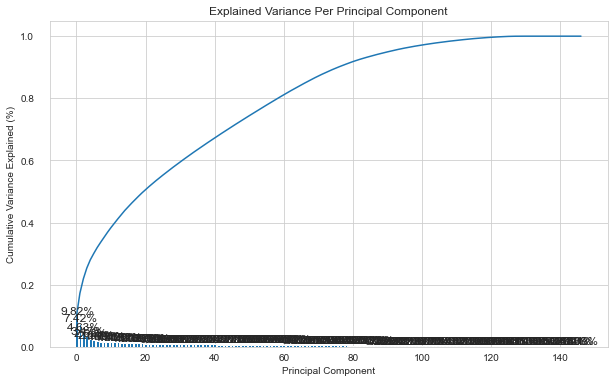

In [93]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

60 components explain 80% of variability in data. We will use this.

In [94]:
# This gives the % contribution of each PC to the total variability, sorted from most important to least important PC
pca.explained_variance_ratio_

array([9.82018280e-02, 7.42346036e-02, 4.63567756e-02, 3.47077814e-02,
       2.62860131e-02, 2.04853296e-02, 1.91429841e-02, 1.69708902e-02,
       1.62499743e-02, 1.61137144e-02, 1.51542248e-02, 1.42695610e-02,
       1.39667477e-02, 1.36749695e-02, 1.32161327e-02, 1.20764347e-02,
       1.16488280e-02, 1.13826780e-02, 1.09492589e-02, 1.07462366e-02,
       1.01122308e-02, 9.86810328e-03, 9.66060459e-03, 9.19036781e-03,
       9.08579460e-03, 8.83210080e-03, 8.70651554e-03, 8.63815232e-03,
       8.44538643e-03, 8.36698013e-03, 8.20015591e-03, 8.10822384e-03,
       8.04706088e-03, 7.99499629e-03, 7.84361169e-03, 7.71033003e-03,
       7.66998420e-03, 7.62737377e-03, 7.53368224e-03, 7.46908371e-03,
       7.41370898e-03, 7.39441226e-03, 7.34329067e-03, 7.26108627e-03,
       7.18367635e-03, 7.15979789e-03, 7.15788528e-03, 7.08995407e-03,
       7.02447568e-03, 6.97422462e-03, 6.95042332e-03, 6.92489172e-03,
       6.88119066e-03, 6.81894934e-03, 6.80782671e-03, 6.79646518e-03,
      

In [95]:
# Re-apply PCA to the data while selecting for number of components to retain.

#Instantiate PCA using 60 components
pca= PCA(n_components=60, random_state =42)

# Fit pca model to data
pca.fit(df_30_scaled)

# Transform dataframe using Principal components
X_pca = pca.transform(df_30_scaled)

In [96]:
X_pca.shape

(798061, 60)

Dataframe has been transformed to a numpy array with each of the 60 principal components (eigenvectors) in columns, instead of the 147 columns, and records in rows.

In [97]:
# Weight (eigenvalues, loadings) contribution/importance of each engineered PC
pca.components_.shape

(60, 147)

In [98]:
# Weight (eigenvalues, loadings) contribution/importance of each engineered PC
pca.components_

array([[-0.10108619,  0.01580401, -0.20409735, ..., -0.10779371,
         0.17997158, -0.10938571],
       [ 0.22717322,  0.04305281,  0.07080894, ..., -0.01757249,
         0.07193681, -0.00087524],
       [ 0.01639944, -0.3463097 ,  0.12579814, ...,  0.06788742,
         0.02366211, -0.0167164 ],
       ...,
       [ 0.03422695, -0.01832994,  0.0097654 , ...,  0.07012287,
         0.00968993, -0.00068166],
       [ 0.0383855 ,  0.03326183, -0.00540717, ...,  0.0506891 ,
         0.01606603,  0.01522193],
       [ 0.06018337, -0.05705816, -0.0038333 , ...,  0.04190007,
        -0.04336978,  0.02378657]])

### Discussion 2.2: Perform Dimensionality Reduction

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)*

From the scree plot,  
- 80 principal components can capture 90% of the variability in the data.
- 60 principal components can capture 80% of the variability in the data.

The first 3 principal components explained 9.8%, 7.4% and 4.5% of the variability in the data.

We will proceed with using 60 principal components for subsequent steps, to speed up the time taken for kmeans clusteering

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should (1) map each weight to their corresponding feature name, (2) then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. 

  Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. 

   To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [99]:
# Get dataframe of the 60 components and their weights/loadings for the 150 feaures
feat_weights = pd.DataFrame(pca.components_, columns=list(df_30_scaled.columns))

In [100]:
feat_weights.shape

(60, 147)

In [101]:
# Sort the weights for each component, and extract the top 5 and bottom 5 features
feat_weights_pc1 =feat_weights.iloc[0].sort_values(ascending=False)
feat_weights_pc1 = feat_weights_pc1.head().append(feat_weights_pc1.tail())

feat_weights_pc2 =feat_weights.iloc[1].sort_values(ascending=False)
feat_weights_pc2 = feat_weights_pc2.head().append(feat_weights_pc2.tail())

feat_weights_pc3 =feat_weights.iloc[2].sort_values(ascending=False)
feat_weights_pc3 = feat_weights_pc3.head().append(feat_weights_pc3.tail())

In [102]:
feat_weights_pc1

LP_STATUS_GROB_1.0    0.200761
HH_EINKOMMEN_SCORE    0.187115
PLZ8_ANTG3            0.181680
wealth                0.179972
PLZ8_ANTG4            0.175461
KBA05_ANTG1          -0.182234
PLZ8_ANTG1           -0.182561
KBA05_GBZ            -0.182645
MOBI_REGIO           -0.189636
FINANZ_MINIMALIST    -0.204097
Name: 0, dtype: float64

Text(0.5, 1.0, 'Features and their weights for first principal component')

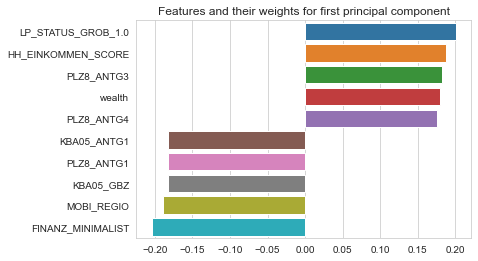

In [103]:
# Plot top5 and bottom 5 features and their weights for the 1st principal component
sns.barplot(y=feat_weights_pc1.index, x=feat_weights_pc1.values)
plt.title("Features and their weights for first principal component")

##### The top 5 features positively correlated with  PC1 and their weight (eigenvalues, loadings) contributions to the PC are:  #####

| Feature | Description |
| --- | --- | 
| LP_STATUS_GROB_1.0 | Social_status by income |
| HH_EINKOMMEN_SCORE | Estimated household net income |
| PLZ8_ANTG3 | Number of 6-10 family houses in the PLZ8 region |
| wealth | Wealth |
| PLZ8_ANTG4 | Number of 10+ family houses in the PLZ8 region |

Most of these features primarily measure wealth. It is hard to interpret what the PLZ8 variable means without domain knowledge. But suppose we make a guess that it relates to the how developed is the place where an individual resides in. A wealthier person may be more disposed to living in an area with more houses and possibly more developed with amenities.

##### The bottom 5 features negatively correlated with PC1 and their weight (eigenvalues, loadings) contributions to the PC are: #####
| Feature | Description |
| --- | --- | 
| KBA05_ANTG1 | Number of 1-2 family houses in the microcell RR3 |
| PLZ8_ANTG1 | Number of 1-2 family houses in the PLZ8 region | 
| KBA05_GBZ | Number of buildings in the microcell |
| MOBI_REGIO | Movement patterns |
| FINANZ_MINIMALIST | MINIMALIST: low financial interest |

Similarly, these features which are negatively correlated with PC1 seem to be surrogate measures of wealth. 

In summary, increasing wealth is positively correlated with PC1 whereas decreasing wealth is negatively correlated with PC1. Put in another way, PC1 separates the data into two demographic segments based on high/low wealth.

In [104]:
feat_weights_pc2

ALTERSKATEGORIE_GROB     0.227173
FINANZ_VORSORGER         0.213056
ZABEOTYP_3               0.200513
SEMIO_ERL                0.178667
SEMIO_LUST               0.159028
SEMIO_TRADV             -0.203811
SEMIO_REL               -0.210383
FINANZ_UNAUFFAELLIGER   -0.212074
FINANZ_SPARER           -0.218309
generation              -0.224992
Name: 1, dtype: float64

Text(0.5, 1.0, 'Features and their weights for second principal component')

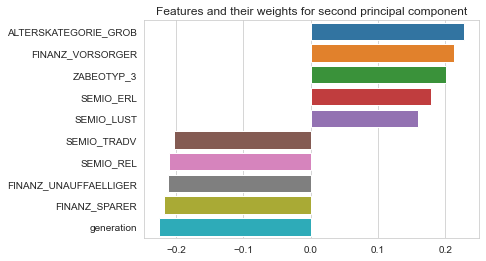

In [105]:
# Plot top5 and bottom 5 features and their weights for the 2nd principal component
sns.barplot(y=feat_weights_pc2.index, x=feat_weights_pc2.values)
plt.title("Features and their weights for second principal component")

##### The Top 5 attributes that are positively correlated with PC2: #####

| Feature | Description |
| --- | --- | 
| ALTERSKATEGORIE_GROB |Estimated age |
| FINANZ_VORSORGER | High Financial typology |
| ZABEOTYP_3 | Energy consumption typology |
| SEMIO_ERL | Event-oriented, personality |
| SEMIO_LUST | Sensual-minded, personality |

##### The bottom 5 attributes that are negatively correlated with PC2: #####
| Feature | Description |
| --- | --- | 
| SEMIO_TRADV | traditional-minded |
| SEMIO_REL | religious |
| FINANZ_UNAUFFAELLIGER | inconspicuous, financial typology |
| FINANZ_SPARER | money saver |
| generation | generation |

The information encoded in PC2 relates to a mixture of mostly personality attributes along with wealth and age.

In [106]:
feat_weights_pc3

SEMIO_VERT     0.319745
SEMIO_FAM      0.261692
SEMIO_SOZ      0.257890
SEMIO_KULT     0.252577
FINANZTYP_5    0.135555
SEMIO_ERL     -0.208032
SEMIO_KRIT    -0.267646
SEMIO_DOM     -0.285660
SEMIO_KAEM    -0.316174
ANREDE_KZ     -0.346310
Name: 2, dtype: float64

Text(0.5, 1.0, 'Features and their weights for third principal component')

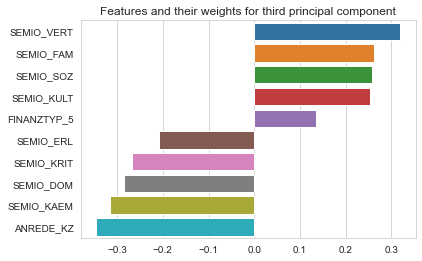

In [107]:
# Plot top5 and bottom 5 features and their weights for the third principal component

sns.barplot(y=feat_weights_pc3.index, x=feat_weights_pc3.values)
plt.title("Features and their weights for third principal component")

##### The Top 5 attributes that are positively correlated with PC3: #####
| Feature | Description |
| --- | --- | 
| SEMIO_VERT | dreamful |
| SEMIO_FAM | family-minded |
| SEMIO_SOZ | socially-minded |
| SEMIO_KULT | cultural-minded |
| FINANZTYP_5 | inconspicious financial type |

##### The bottom 5 attributes that are negatively  correlated with PC3: #####
| Feature | Description |
| --- | --- | 
| SEMIO_ERL | event-oriented |
| SEMIO_KRIT | critical-minded |
| SEMIO_DOM | dominant-minded |
| SEMIO_KAEM | combative attitude |
| ANREDE_KZ | gender |

The PC3 largely captures information about personality traits. 

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

##### Making sense of the .ncomponents attribute ##### 
Each principal component (PC, eiggen vector) is a engineered feature that is the linear combination of the weights ("loadings", eigen values) of each original feature multiplied by the feature value.

E.g. PC1 = w1\*feature1 + w2\*feature2 + w3\*feature3....etc  

A larger the  value, the more that feature contributes to the PC.
The sign of the weight indicates the direction of the direction: + for positive correlation, - for negative correlation.

The pca.n_components_atrtibute yields a 2D numpy array where each row index is the PC eigenvector and the column indices are the original features, which is 147 in our case, after preprocessing. The rows are sorted in descending order of PC importance.

The values represent the weights  that each of the 147 original feature contributes to the PC.
The absolute values of the weights indicate the importance of that attribute to the PC.
Positive weights represent positive correlation, and negative weights represent negative correlation.

##### Intepretation of the first 3 principal components ##### 
PC1
- Most of the features primarily measure wealth. It is hard to interpret what the PLZ8 variable means without domain knowledge. But suppose we make a guess that it relates to the how developed is the place where an individual resides in. A wealthier person may be more disposed to living in an area with more houses and possibly more developed with amenities.

PC2
- Relates to a mixture of mostly personality attributes along with wealth and age.

PC3
- Largely captures information about personality traits.

Reference:
https://www.youtube.com/watch?v=BiuwDI_BbWw&t=10s


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [108]:
''' Remove the quote block if need to run k means over a range of clusters
# As k means takes a long time to run, I will use miniBatch KMeans instead to help select the number of clusters.

#Fit Kmeans for a range of k clusters, and calculate SSE for each k

from sklearn.cluster import KMeans

# Empty list to hold sse
sse =[]

for k in range(1,21):
    
    # Intialize K Means
    kmeans = KMeans(n_clusters =k, random_state =42)

    # Fit k means clustering on the transformed dataframe with PC
    kmeans.fit(X_pca)

    # Assign SSE to k element of dictionary
    sse.append(kmeans.inertia_)
    
#elbow plot
plt.figure(figsize =(10,8))
plt.plot(range(1,21), sse, marker='o', linestyle='--', color ='r')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('KMeans with PCA clustering')
plt.show()

'''

" Remove the quote block if need to run k means over a range of clusters\n# As k means takes a long time to run, I will use miniBatch KMeans instead to help select the number of clusters.\n\n#Fit Kmeans for a range of k clusters, and calculate SSE for each k\n\nfrom sklearn.cluster import KMeans\n\n# Empty list to hold sse\nsse =[]\n\nfor k in range(1,21):\n    \n    # Intialize K Means\n    kmeans = KMeans(n_clusters =k, random_state =42)\n\n    # Fit k means clustering on the transformed dataframe with PC\n    kmeans.fit(X_pca)\n\n    # Assign SSE to k element of dictionary\n    sse.append(kmeans.inertia_)\n    \n#elbow plot\nplt.figure(figsize =(10,8))\nplt.plot(range(1,21), sse, marker='o', linestyle='--', color ='r')\nplt.xlabel('Number of clusters')\nplt.ylabel('SSE')\nplt.title('KMeans with PCA clustering')\nplt.show()\n\n"

In [109]:
# Takes a while to run but much faster than K Means
from sklearn.cluster import MiniBatchKMeans

# Fit minibatch Kmeans for a range of k clusters, and calculate SSE for each k

# Empty list to hold sse
mbk_sse =[]

for k in range(1,30):
    
    # Intialize MiniBatch K Means
    mbk_means = MiniBatchKMeans(n_clusters =k, random_state =42)

    # Fit k means clustering on transformed dataframe with PC
    mbk_means.fit(X_pca)

    # Assign SSE to k element of dictionary
    mbk_sse.append(mbk_means.inertia_)

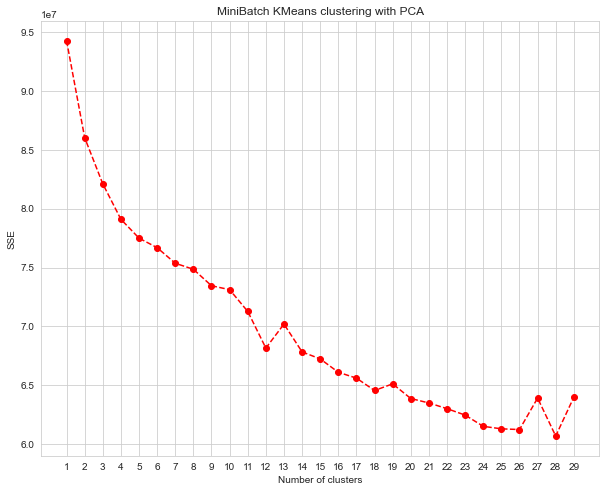

In [110]:
# Elbow plot from miniBatch Kmeans to determine optimal k

plt.figure(figsize =(10,8))
plt.plot(range(1,30), mbk_sse, marker='o', linestyle='--', color ='r')
plt.xticks(range(1, 30))
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('MiniBatch KMeans clustering with PCA')
plt.show()

From the elbow plot, SSE decreases steeply for the first few clusters, and then the rate of decline is gradual until about 11-13 clusters.It is a little difficult to pinpoint the "elbow" in the plot so let's see whether the KneeLocator may be helpful here.

In [111]:
# Use KneeLocator to help us locate elbow more precisely

from kneed import KneeLocator
kl = KneeLocator(range(1, 30), mbk_sse, curve="convex", direction="decreasing")
kl.elbow

12

In [112]:
# Having found the k from MiniBatch Kmeans, we will now fit the k-means model with the 12 clusters and obtain
# cluster predictions for the general population demographics data.

from sklearn.cluster import KMeans

# Intialize K Means
kmeans = KMeans(n_clusters = 12, random_state =42)

# Fit k means clustering on transformed dataframe with PC
kmeans.fit(X_pca)

# Extract cluster predictions; Alternatively, we can also use the kmeans.predict method
clusters = kmeans.labels_

In [113]:
# Array of cluster label assignments
clusters

array([2, 9, 4, ..., 7, 5, 8])

In [114]:
# Glue cluster labels to dataframe (df_30, unscaled, imputed NaN)
df_30['cluster'] = clusters

df_30.shape

(798061, 148)

In [115]:
df_30['cluster'].value_counts(normalize=True)

2     0.129004
4     0.119228
8     0.102967
3     0.099630
5     0.086749
6     0.078945
7     0.076536
10    0.071994
9     0.064481
0     0.064202
1     0.061187
11    0.045077
Name: cluster, dtype: float64

### Discussion 3.1: Apply Clustering to General Population

*(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)*

For this part of the project, we worked with the PCA-transformed dataset from the general population. From 147 columns (after preprocessing), we re-represented them in a reduced feature space of 60 principal components.

To determine the number of clusters to use, we initially fitted a range of k clusters from 1 to 30. However Kmeans was rather slow due to the sheer size of the dataset. So we switched to MiniBatchK Means for this task. 

Next we plotted the sse (Sum of squared distances of samples to their closest cluster center) given by the .inertia_ attribute for each cluster number.  This gives us the scree or elbow plot which will help us determine the number of clusters to re-run the KMeans algorithmn on.

From the elbow plot,  we see the sse declines steeply for the first few clusters and then less gradually, flattening around 9 and dipping more slowly thereafter til 11-13. Becuase the elbow joint was a little hard to pinpoint, KneeLocator was used, which gave a cluster number of 12, consistent with the visual examination. 

In other words, it means the general population can be discerned into 12 different clusters based on their attributes.

So we initiated a KMeans model with 12 clusters, fitted it to the PCA-transformed dataframe and used the .labels_ attribute to obtain the cluster label that each individual (=row) in the dataframe belongs to. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. **That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! ** Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [116]:
# Load in the customer demographics data.
cust =  pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep = ";")

In [117]:
cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               191652 non-null  int64  
 1   ALTERSKATEGORIE_GROB   191652 non-null  int64  
 2   ANREDE_KZ              191652 non-null  int64  
 3   CJT_GESAMTTYP          188439 non-null  float64
 4   FINANZ_MINIMALIST      191652 non-null  int64  
 5   FINANZ_SPARER          191652 non-null  int64  
 6   FINANZ_VORSORGER       191652 non-null  int64  
 7   FINANZ_ANLEGER         191652 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  191652 non-null  int64  
 9   FINANZ_HAUSBAUER       191652 non-null  int64  
 10  FINANZTYP              191652 non-null  int64  
 11  GEBURTSJAHR            191652 non-null  int64  
 12  GFK_URLAUBERTYP        188439 non-null  float64
 13  GREEN_AVANTGARDE       191652 non-null  int64  
 14  HEALTH_TYP             191652 non-nu

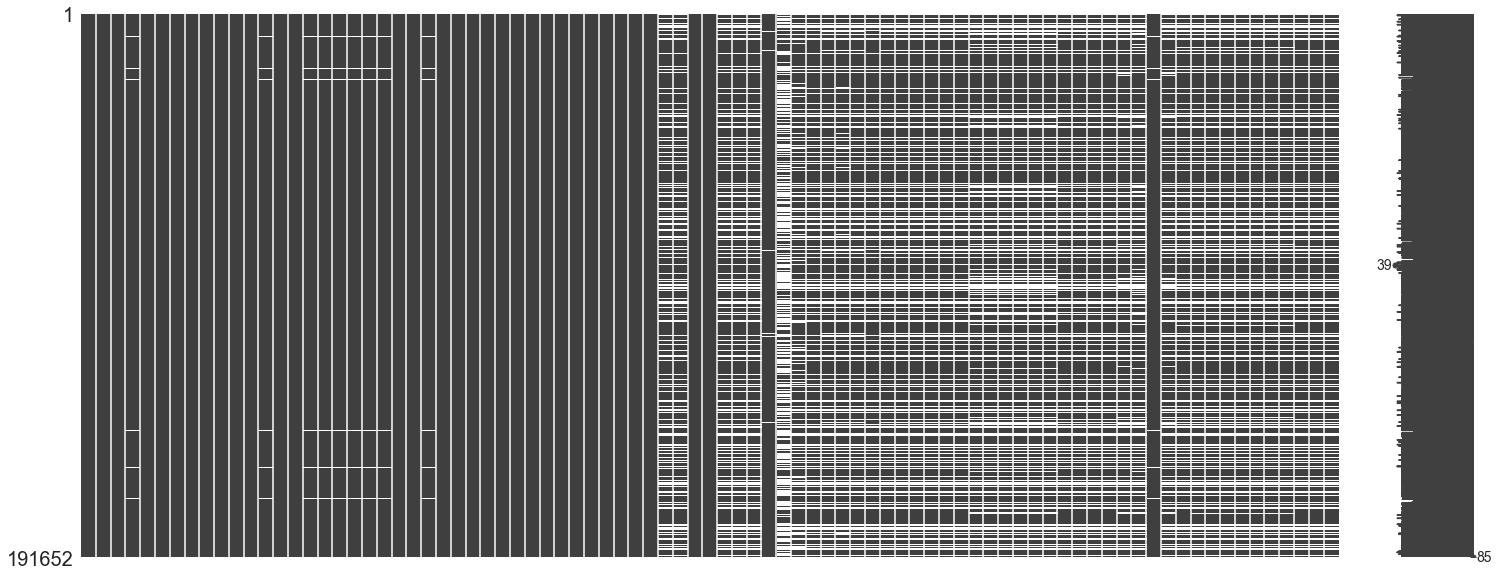

In [118]:
# Investigate missingness in the customer dataset.
missingno.matrix(cust)

On first inspection, the customers data set has similar patterns of missingness as the general dataset. So let's go ahead and process it in the same manner as the general dataset.

# Apply preprocessing, feature transformation, and clustering from the general demographics onto the customer data, obtaining cluster predictions for the customer demographics data.



#### Apply preprocessing, feature transformation, and clustering from the onto the customer data

In [119]:
# Apply clean_data function which standardise missing values to NaN, remove columns and rows with excessive missing data
# Need to load in features summary and do initial processing before running this function
df_cust = clean_data(cust)

In [120]:
df_cust.shape

(141708, 147)

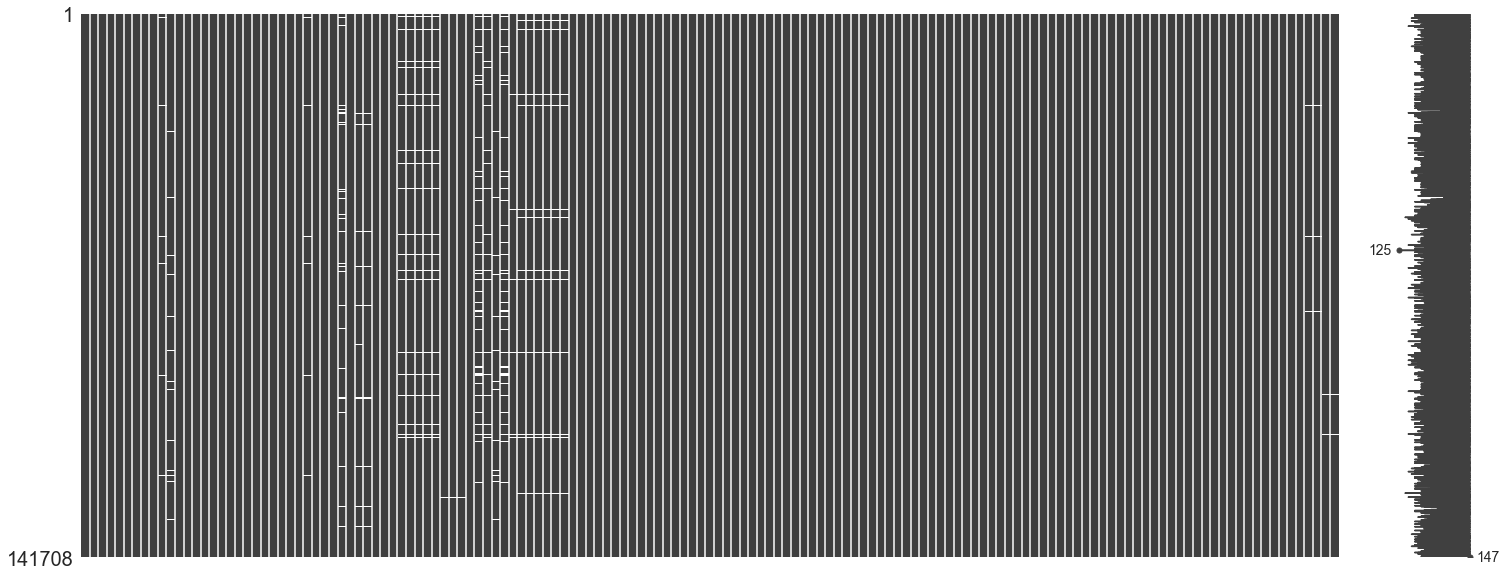

In [121]:
# Visualize data after clean up 
missingno.matrix(df_cust)

In [122]:
# Impute missing data using most_frequent strategy
# Note: Using the Imputer object which has has been instantiated and fitted earlier, so only .transform is needed.
df_cust_imputed = pd.DataFrame(imputer.transform(df_cust.values), columns=df_cust.columns)

# Confirm all missing data imputed
print("Missing data count: ", df_cust_imputed.isnull().sum().sum())

Missing data count:  0


In [123]:
df_cust_imputed.shape

(141708, 147)

In [124]:
# Confirm the number of columns in cleaned customer dataframe and general dataframe are the same

for c in df_30.columns:
    if c not in df_cust.columns:
        print(c)

cluster


In [125]:
# Scale data using the Standard Scaler object which we had created earlier
df_cust_scaled = scaler.transform(df_cust_imputed)

In [126]:
# Transform data using pca model which we had fitted on the general dataset earlier
X_cust_pca = pca.transform(df_cust_scaled)

In [127]:
# Predict cluster labels from the using the kmeans model  created earlier.
predictions = kmeans.predict(X_cust_pca)

df_cust['cluster'] = predictions
df_cust.shape

(141708, 148)

In [128]:
df_cust['cluster'].value_counts()

6     42545
4     28085
11    15425
9     12654
1     10604
3      9441
8      9168
0      5215
10     4692
7      1453
2      1406
5      1020
Name: cluster, dtype: int64

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [129]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

s1 = pd.Series(df_30['cluster'].value_counts(normalize = True), name ="general")
s2 = pd.Series(df_cust['cluster'].value_counts(normalize =True), name = "customer")

# Concatenate the value counts of cluster labels into a single dataframe
comparison = pd.concat([s1, s2], axis=1)

# Create diff column
comparison['diff'] = comparison['customer'] - comparison['general']

# Print dataframe
comparison.sort_values(by = 'diff')

,general,customer,diff
2,0.129004,0.009922,-0.119082
5,0.086749,0.007198,-0.079551
7,0.076536,0.010253,-0.066282
10,0.071994,0.033110,-0.038884
8,0.102967,0.064696,-0.038271
3,0.099630,0.066623,-0.033007
0,0.064202,0.036801,-0.027401
1,0.061187,0.074830,0.013643
9,0.064481,0.089296,0.024815
11,0.045077,0.108851,0.063774


####  What kinds of people are part of a cluster that is overrepresented in the customer data compared to the general population?



Text(0, 0.5, 'Proportion of dataset')

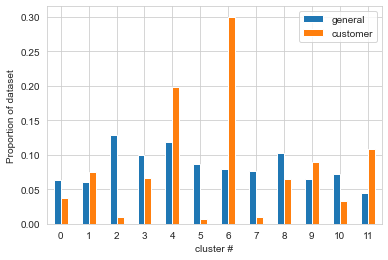

In [130]:
comparison[['general', 'customer']].plot(kind='bar', rot = 0)
plt.xlabel('cluster #')
plt.ylabel('Proportion of dataset')

Text(0, 0.5, 'Difference in proportion of cluster label counts')

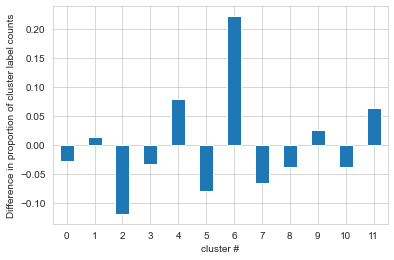

In [131]:
comparison['diff'].plot(kind='bar', rot = 0)
plt.xlabel('cluster #')
plt.ylabel('Difference in proportion of cluster label counts')

Customers are over-represented in cluster 6 by +22% and under-represented in cluster 2 by -12%

#### What kinds of people are part of a cluster that is over-represented in the customer data compared to the general population?


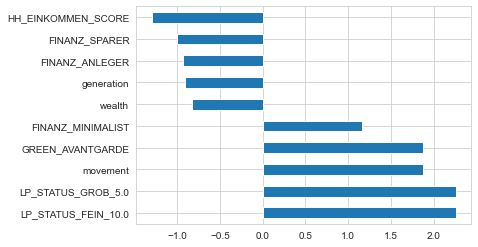

In [132]:
## Examine demographic attributes associated with cluster 6 where customers are over-represented

# Get feature weights of cluster center by inverse transforming the pca object created earlier
# This yields a numpy array of shape (150, ) where the 150 are the feature names in the scaled dataframe
cluster_feat_weights=pca.inverse_transform(kmeans.cluster_centers_[6]) 

# Convert feature weights array into pandas dataframe with feature names
cluster_feat_weights_df =pd.DataFrame.from_dict(
                            dict(zip(df_30_scaled.columns, cluster_feat_weights)),  
                            orient='index', columns=['feature_weights'])

# Sort by weights in descending order
cluster_feat_weights_df = cluster_feat_weights_df['feature_weights'].sort_values(ascending=False)

# Extract the top 5 positively correlated and bottom 5 negatively correlated weights
cluster_feat_weights_df = cluster_feat_weights_df.head(5).append(cluster_feat_weights_df.tail(5))

# Visual with horizontal bar plot
cluster_feat_weights_df.plot.barh()

In [133]:
cluster_feat_weights.shape

(147,)

Positive correlated features
- LP_STATUS_FEIN_10.0, top earners
- LP_STATUS_GROB_5.0, top earners 
- movement,  avantgarde vs. mainstream
- GREEN_AVANTGARDE, Membership in environmental sustainability as part of youth
- FINANZ_MINIMALIST,  low financial interest

Negatively correlated features
- HH_EINKOMMEN_SCORE, household net income
- FINANZ_SPARER, money-saver
- FINANZ_ANLEGER,investor
- generation
- wealth

#### What kinds of people are part of a cluster that is underrepresented in the customer data compared to the general population?


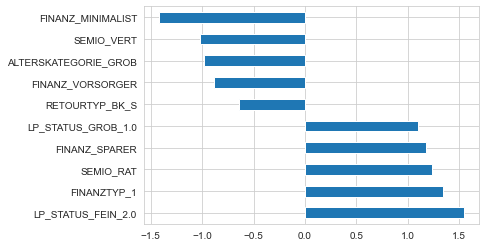

In [134]:
## Examine demographic attributes associated with cluster 2 where customers are under-represented

# Get feature weights of cluster center by inverse transforming the pca object created earlier
# This yields a numpy array of shape (150, ) where the 150 are the feature names in the scaled dataframe
cluster_feat_weights = pca.inverse_transform(kmeans.cluster_centers_[2]) 

# Convert feature weights array into pandas dataframe with feature names
cluster_feat_weights_df = pd.DataFrame.from_dict(
                            dict(zip(df_30_scaled.columns[:-1], cluster_feat_weights)),  
                            orient='index', columns=['feature_weights'])

# Sort by weights in descending order
cluster_feat_weights_df = cluster_feat_weights_df['feature_weights'].sort_values(ascending=False)

# Extract the top 5 positively correlated and bottom 5 negatively correlated weights
cluster_feat_weights_df = cluster_feat_weights_df.head(5).append(cluster_feat_weights_df.tail(5))

# Visual with horizontal bar plot
cluster_feat_weights_df.plot.barh()

Positively correlated features
- LP_STATUS_FEIN_2.0,  orientation-seeking low-income earners
- FINANZTYP_1, low financial interest (MINIMALIST)
- SEMIO_RAT, rational
- FINANZ_SPARER, money-saver
- LP_STATUS_GROB_1.0, low income

Negatively correlated features
- FINANZ_MINIMALIST, low financial interest
- SEMIO_VERT, dreamful
- ALTERSKATEGORIE_GROB, Estimated age based on given name analysis
- FINANZ_VORSORGER,  be prepared
- RETOURTYP_BK_S, Returning customer frequency


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

**Cluster 6 where customers are Over-represented by 20%**

Members in cluster 2 mostly mapped with demographic attributes that suggest greater financial ability,and have interest in environmental causes.

Positive correlated features
- LP_STATUS_FEIN_10.0, top earners
- LP_STATUS_GROB_5.0, top earners 
- movement,  avantgarde vs. mainstream
- GREEN_AVANTGARDE, Membership in environmental sustainability as part of youth
- FINANZ_MINIMALIST,  low financial interest

Negatively correlated features
- HH_EINKOMMEN_SCORE, household net income
- FINANZ_SPARER, money-saver
- FINANZ_ANLEGER,investor
- generation
- wealth

**Cluster 2 where customers are under-represented by 12%** 

THese demographic attributes associated with this cluster seem to suggest an individual who is less wealthier, older, less likely to be a repeat customer.

Positively correlated features
- LP_STATUS_FEIN_2.0,  orientation-seeking low-income earners
- FINANZTYP_1, low financial interest (MINIMALIST)
- SEMIO_RAT, rational
- FINANZ_SPARER, money-saver
- LP_STATUS_GROB_1.0, low income

Negatively correlated features
- FINANZ_MINIMALIST, low financial interest
- SEMIO_VERT, dreamful
- ALTERSKATEGORIE_GROB, Estimated age based on given name analysis
- FINANZ_VORSORGER,  be prepared
- RETOURTYP_BK_S, Returning customer frequency

### Application of findings to business ###
The company can launch marketing campaigns to reach out to  audiences with attributes that coincides with the demographic profile of cluster 2. This will be expected to yield hits that result in sales.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.